In [1]:
%matplotlib widget
%matplotlib inline
import torch
import torch.nn as nn
import pickle
import time
import copy
import os
from queue import LifoQueue
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.tree import DecisionTreeClassifier
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances
import network.cpc
from network.cpc import CDCK2
from utils.MatplotlibUtils import reduce_dims_and_plot
from utils.ClassificationUtiols import onehot_coding
from soft_decision_tree.sdt_model import SDT
from sklearn import tree as tt

# IPython.OutputArea.auto_scroll_threshold = 9999;

# Load the model and the dataset

In [2]:
model_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt'
dataset_path = r'/home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/data/test_data_protocol_4.file'

print(f"Load the model from: {model_path}")
model = torch.load(model_path, map_location='cpu')

with open(dataset_path, 'rb') as fp:
    dataset = pickle.load(fp)

all_sensors = dataset.dataset.all_signals    
print(f"sensor names: ({len(all_sensors)} total)")

for s in all_sensors:
    print(f"- {s}")
    
print(f"Multihorizon size of the model: {model.timestep}")
print(f"Test split ratio: {len(dataset) / len(dataset.dataset)}")
print(f"Total number of windows in the dataset (without splitting): {len(dataset.dataset)}")

Load the model from: /home/eitan.k/EntangledExplainableClustering/knn_loss_batch_512_k_128/models/epoch_40.pt
sensor names: (18 total)
- speed
- steering_angle
- wheel_speed_0
- wheel_speed_1
- wheel_speed_2
- wheel_speed_3
- accelerometer_0
- accelerometer_1
- accelerometer_2
- gyro_0
- gyro_1
- gyro_2
- gyro_bias_0
- gyro_bias_1
- gyro_bias_2
- gyro_uncalibrated_0
- gyro_uncalibrated_1
- gyro_uncalibrated_2
Multihorizon size of the model: 30
Test split ratio: 0.2
Total number of windows in the dataset (without splitting): 101465


In [3]:
batch_size = 500
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Extract representations

In [4]:
projections = torch.tensor([])
samples = torch.tensor([])
device = 'cuda'
model = model.to(device).eval()

with torch.no_grad():
    bar = tqdm(total=len(loader.dataset))
    for batch in loader:
        hidden = CDCK2.init_hidden(len(batch))
        batch = batch.to(device)
        hidden = hidden.to(device)

        y = model.predict(batch, hidden).detach().cpu()
        projections = torch.cat([projections, y.detach().cpu()])
        samples = torch.cat([samples, batch.detach().cpu()])
        bar.update(y.shape[0])

  0%|          | 0/20293 [00:00<?, ?it/s]

# Fit GMM and calculate indices

In [5]:
scores = []
best_score = float('inf')
clusters = None
range_ = list(range(5, 80))
for k in tqdm(range_):
    y = GaussianMixture(n_components=k).fit_predict(projections)
    cur_score = davies_bouldin_score(projections, y)
    scores.append(cur_score)
    
    if cur_score < best_score:
        best_score = cur_score
        clusters = y

  0%|          | 0/75 [00:00<?, ?it/s]

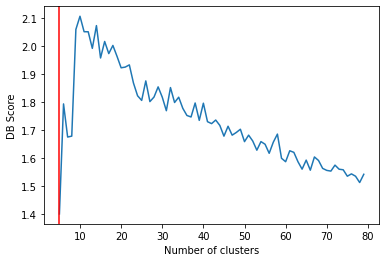

{0, 1, 2, 3, 4}


In [6]:
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('DB Score')
plt.plot(range_, scores)
best_k = range_[np.argmin(scores)]
plt.axvline(best_k, color='r')
plt.show()

labels = set(clusters)
print(labels)

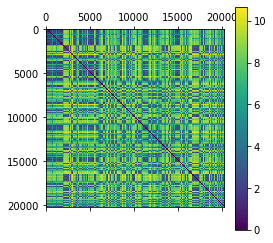

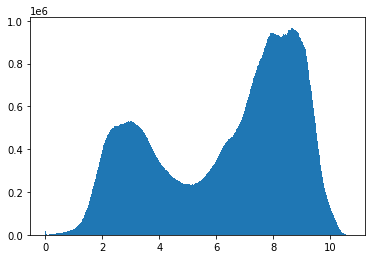

In [7]:
distances = pairwise_distances(projections)
# distances = np.triu(distances)
distances_f = distances.flatten()

plt.matshow(distances)
plt.colorbar()
plt.figure()
plt.hist(distances_f[distances_f > 0], bins=1000)
plt.show()

# Visualize with T-SNE

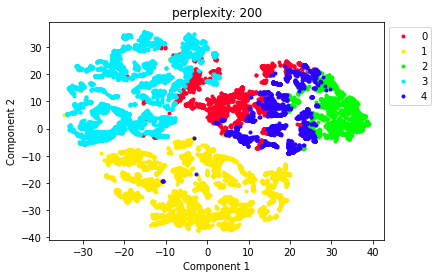

In [8]:
perplexity = 200

p = reduce_dims_and_plot(projections,
                         y=clusters,
                         title=f'perplexity: {perplexity}',
                         file_name=None,
                         perplexity=perplexity,
                         library='Multicore-TSNE',
                         perform_PCA=False,
                         projected=None,
                         figure_type='2d',
                         show_figure=True,
                         close_figure=False,
                         text=None)    

# Train a Soft-Decision-Tree given the self-labels

## Prepare the dataset

In [9]:
# unnormalized_samples = samples.clone()

# for col, sensor in enumerate(tqdm(dataset.dataset.all_signals)):
#     denormalizer = dataset.dataset.get_denormalization_for_sensor(sensor)
#     unnormalized_samples[:, col, :] = denormalizer(unnormalized_samples[:, col, :])

sampled = samples[..., range(0, samples.shape[-1], 200)]

samples_f = sampled.flatten(1)
tree_dataset = list(zip(samples_f, clusters))
batch_size = 2000
tree_loader = torch.utils.data.DataLoader(tree_dataset, batch_size=batch_size, shuffle=True)

# Define how we prune the weights of a node

In [10]:
def prune_node(node_weights, factor=1):
    w = node_weights.cpu().detach().numpy()
    mean_ = np.mean(w)
    std_ = np.std(w)
    node_weights[((mean_ - std_ * factor) < node_weights) & (node_weights < (mean_ + std_ * factor))] = 0
    return node_weights

def prune_node_keep(node_weights, keep=4):
    w = node_weights.cpu().detach().numpy()
    throw_idx = np.argsort(abs(w))[:-keep]
    node_weights[throw_idx] = 0
    return node_weights

def prune_tree(tree_, factor):
    new_weights = tree_.inner_nodes.weight.clone()
    for i in range(new_weights.shape[0]):
        res = prune_node_keep(new_weights[i, :], factor)
        new_weights[i, :] = res

    with torch.no_grad():
        tree_.inner_nodes.weight.copy_(new_weights)
        
def sparseness(x):
    s = []
    for i in range(x.shape[0]):
        x_ = x[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        s.append(sp)
    return np.mean(s)

def compute_regularization_by_level(tree):
    total_reg = 0
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_level = np.floor(np.log2(i+1))
        node_reg = torch.norm(tree.inner_nodes.weight[i].view(-1), 2)
        total_reg += 2**(-cur_level) * node_reg
    return total_reg

def show_sparseness(tree):
    avg_sp = sparseness(tree.inner_nodes.weight)
    print(f"Average sparseness: {avg_sp}")
    layer = 0
    sps = []
    for i in range(tree.inner_nodes.weight.shape[0]):
        cur_layer = int(np.floor(np.log2(i+1)))
        if cur_layer != layer:
            print(f"layer {layer}: {np.mean(sps)}")
            sps = []
            layer = cur_layer

        x_ = tree.inner_nodes.weight[i, :]
        sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
        sps.append(sp)
        
    return avg_sp

## Training configurations

In [11]:
def do_epoch(model, loader, device, log_interval, losses, accs, epoch, iteration):
    model = model.train()
    for batch_idx, (data, target) in enumerate(loader):
        iteration += 1
        data, target = data.to(device), target.to(device)

        output, penalty = tree.forward(data)

        # Loss
        loss_tree = criterion(output, target.view(-1))

        # Penalty
        loss_tree += penalty

        # Sparse regularization
#         fc_params = torch.cat([x.view(-1) for x in tree.inner_nodes.parameters()])
#         regularization = sparsity_lamda * torch.norm(fc_params, 2)
        regularization = sparsity_lamda * compute_regularization_by_level(tree)
        loss = loss_tree

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        pred = output.data.max(1)[1]
        correct = pred.eq(target.view(-1).data).sum()
        accs.append(correct.item() / data.size()[0])

        # Print training status
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch:02d} | Batch: {batch_idx:03d} / {len(loader):03d} | Total loss: {loss.item():.3f} | Reg loss: {regularization.item():.3f} | Tree loss: {loss_tree.item():.3f} | Accuracy: {correct.item() / data.size()[0]:03f} | {round((time.time() - start_time) / iteration, 3)} sec/iter")
            
    return iteration


In [12]:
lr = 5e-3
weight_decay = 5e-4
sparsity_lamda = 2e-3
epochs = 500
output_dim = len(set(clusters))
log_interval = 1
tree_depth = 12

In [13]:
tree = SDT(input_dim=samples_f.shape[1], output_dim=len(labels), depth=tree_depth, lamda=1e-3, use_cuda=True)
optimizer = torch.optim.Adam(tree.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
tree = tree.to(device)
clf = DecisionTreeClassifier(max_depth=tree_depth).fit(samples_f, clusters)
print(f"DT accuracy: {clf.score(samples_f, clusters)}")
tree.initialize_from_decision_tree(clf)

DT accuracy: 0.9950229143054256


In [14]:
losses = []
accs = []
sparsity = []

In [15]:
start_time = time.time()
iteration = 0
for epoch in range(epochs):
    # Training
    avg_sp = show_sparseness(tree)
    sparsity.append(avg_sp)
    iteration = do_epoch(tree, tree_loader, device, log_interval, losses, accs, epoch, iteration)
    
    if epoch % 1 == 0:
        prune_tree(tree, factor=5)
        

Average sparseness: 0.08428416273720142
layer 0: 0.988950276243094
layer 1: 0.988950276243094
layer 2: 0.988950276243094
layer 3: 0.8653314917127072
layer 4: 0.7417127071823204
layer 5: 0.6180939226519337
layer 6: 0.5099274861878453
layer 7: 0.3476778314917127
layer 8: 0.22792213397790057
layer 9: 0.11975569751381217
layer 10: 0.05698053349447514
Epoch: 00 | Batch: 000 / 011 | Total loss: 1.562 | Reg loss: 0.020 | Tree loss: 1.562 | Accuracy: 0.354000 | 19.961 sec/iter
Epoch: 00 | Batch: 001 / 011 | Total loss: 1.554 | Reg loss: 0.020 | Tree loss: 1.554 | Accuracy: 0.330500 | 17.621 sec/iter
Epoch: 00 | Batch: 002 / 011 | Total loss: 1.536 | Reg loss: 0.019 | Tree loss: 1.536 | Accuracy: 0.335500 | 16.879 sec/iter
Epoch: 00 | Batch: 003 / 011 | Total loss: 1.523 | Reg loss: 0.019 | Tree loss: 1.523 | Accuracy: 0.334500 | 16.527 sec/iter
Epoch: 00 | Batch: 004 / 011 | Total loss: 1.509 | Reg loss: 0.019 | Tree loss: 1.509 | Accuracy: 0.344000 | 16.325 sec/iter
Epoch: 00 | Batch: 005 / 0

Epoch: 04 | Batch: 008 / 011 | Total loss: 1.459 | Reg loss: 0.016 | Tree loss: 1.459 | Accuracy: 0.493500 | 14.249 sec/iter
Epoch: 04 | Batch: 009 / 011 | Total loss: 1.450 | Reg loss: 0.016 | Tree loss: 1.450 | Accuracy: 0.520000 | 14.264 sec/iter
Epoch: 04 | Batch: 010 / 011 | Total loss: 1.439 | Reg loss: 0.016 | Tree loss: 1.439 | Accuracy: 0.535836 | 14.073 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 05 | Batch: 000 / 011 | Total loss: 1.535 | Reg loss: 0.015 | Tree loss: 1.535 | Accuracy: 0.342500 | 14.214 sec/iter
Epoch: 05 | Batch: 001 / 011 | Total loss: 1.531 | Reg loss: 0.015 | Tree loss: 1.531 | Accuracy: 0.325000 | 14.227 sec/iter
Epoch: 05 | Batch: 002 / 01

Epoch: 09 | Batch: 005 / 011 | Total loss: 1.401 | Reg loss: 0.016 | Tree loss: 1.401 | Accuracy: 0.404500 | 14.179 sec/iter
Epoch: 09 | Batch: 006 / 011 | Total loss: 1.380 | Reg loss: 0.016 | Tree loss: 1.380 | Accuracy: 0.388500 | 14.185 sec/iter
Epoch: 09 | Batch: 007 / 011 | Total loss: 1.356 | Reg loss: 0.016 | Tree loss: 1.356 | Accuracy: 0.390000 | 14.135 sec/iter
Epoch: 09 | Batch: 008 / 011 | Total loss: 1.336 | Reg loss: 0.016 | Tree loss: 1.336 | Accuracy: 0.400000 | 14.144 sec/iter
Epoch: 09 | Batch: 009 / 011 | Total loss: 1.337 | Reg loss: 0.016 | Tree loss: 1.337 | Accuracy: 0.395000 | 14.152 sec/iter
Epoch: 09 | Batch: 010 / 011 | Total loss: 1.339 | Reg loss: 0.016 | Tree loss: 1.339 | Accuracy: 0.392491 | 14.057 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 14 | Batch: 002 / 011 | Total loss: 1.387 | Reg loss: 0.017 | Tree loss: 1.387 | Accuracy: 0.555000 | 14.117 sec/iter
Epoch: 14 | Batch: 003 / 011 | Total loss: 1.362 | Reg loss: 0.017 | Tree loss: 1.362 | Accuracy: 0.555000 | 14.122 sec/iter
Epoch: 14 | Batch: 004 / 011 | Total loss: 1.323 | Reg loss: 0.017 | Tree loss: 1.323 | Accuracy: 0.588500 | 14.128 sec/iter
Epoch: 14 | Batch: 005 / 011 | Total loss: 1.283 | Reg loss: 0.017 | Tree loss: 1.283 | Accuracy: 0.595500 | 14.133 sec/iter
Epoch: 14 | Batch: 006 / 011 | Total loss: 1.256 | Reg loss: 0.017 | Tree loss: 1.256 | Accuracy: 0.585500 | 14.138 sec/iter
Epoch: 14 | Batch: 007 / 011 | Total loss: 1.226 | Reg loss: 0.017 | Tree loss: 1.226 | Accuracy: 0.548500 | 14.106 sec/iter
Epoch: 14 | Batch: 008 / 011 | Total loss: 1.223 | Reg loss: 0.017 | Tree loss: 1.223 | Accuracy: 0.478000 | 14.112 sec/iter
Epoch: 14 | Batch: 009 / 011 | Total loss: 1.202 | Reg loss: 0.017 | Tree loss: 1.202 | Accuracy: 0.484000 | 14.118 sec/iter


Epoch: 19 | Batch: 000 / 011 | Total loss: 1.379 | Reg loss: 0.018 | Tree loss: 1.379 | Accuracy: 0.595000 | 14.089 sec/iter
Epoch: 19 | Batch: 001 / 011 | Total loss: 1.343 | Reg loss: 0.018 | Tree loss: 1.343 | Accuracy: 0.652000 | 14.093 sec/iter
Epoch: 19 | Batch: 002 / 011 | Total loss: 1.311 | Reg loss: 0.018 | Tree loss: 1.311 | Accuracy: 0.656000 | 14.097 sec/iter
Epoch: 19 | Batch: 003 / 011 | Total loss: 1.267 | Reg loss: 0.018 | Tree loss: 1.267 | Accuracy: 0.637000 | 14.101 sec/iter
Epoch: 19 | Batch: 004 / 011 | Total loss: 1.227 | Reg loss: 0.018 | Tree loss: 1.227 | Accuracy: 0.621500 | 14.105 sec/iter
Epoch: 19 | Batch: 005 / 011 | Total loss: 1.191 | Reg loss: 0.018 | Tree loss: 1.191 | Accuracy: 0.627000 | 14.109 sec/iter
Epoch: 19 | Batch: 006 / 011 | Total loss: 1.172 | Reg loss: 0.019 | Tree loss: 1.172 | Accuracy: 0.604000 | 14.113 sec/iter
Epoch: 19 | Batch: 007 / 011 | Total loss: 1.150 | Reg loss: 0.019 | Tree loss: 1.150 | Accuracy: 0.605000 | 14.089 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 24 | Batch: 000 / 011 | Total loss: 1.305 | Reg loss: 0.020 | Tree loss: 1.305 | Accuracy: 0.587000 | 14.083 sec/iter
Epoch: 24 | Batch: 001 / 011 | Total loss: 1.288 | Reg loss: 0.020 | Tree loss: 1.288 | Accuracy: 0.603500 | 14.086 sec/iter
Epoch: 24 | Batch: 002 / 011 | Total loss: 1.245 | Reg loss: 0.020 | Tree loss: 1.245 | Accuracy: 0.584000 | 14.09 sec/iter
Epoch: 24 | Batch: 003 / 011 | Total loss: 1.192 | Reg loss: 0.020 | Tree loss: 1.192 | Accuracy: 0.616000 | 14.093 sec/iter
Epoch: 24 | Batch: 004 / 011 | Total loss: 1.163 | Reg loss: 0.020 | Tree loss: 1.163 | Accuracy: 0.665000 | 14.096 sec/iter
Epoch: 24 | Batch: 005 / 011

Epoch: 28 | Batch: 008 / 011 | Total loss: 1.028 | Reg loss: 0.021 | Tree loss: 1.028 | Accuracy: 0.601500 | 14.084 sec/iter
Epoch: 28 | Batch: 009 / 011 | Total loss: 1.026 | Reg loss: 0.021 | Tree loss: 1.026 | Accuracy: 0.589500 | 14.088 sec/iter
Epoch: 28 | Batch: 010 / 011 | Total loss: 0.993 | Reg loss: 0.021 | Tree loss: 0.993 | Accuracy: 0.610922 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 29 | Batch: 000 / 011 | Total loss: 1.254 | Reg loss: 0.021 | Tree loss: 1.254 | Accuracy: 0.601000 | 14.08 sec/iter
Epoch: 29 | Batch: 001 / 011 | Total loss: 1.218 | Reg loss: 0.021 | Tree loss: 1.218 | Accuracy: 0.595000 | 14.083 sec/iter
Epoch: 29 | Batch: 002 / 011

Epoch: 33 | Batch: 005 / 011 | Total loss: 1.043 | Reg loss: 0.022 | Tree loss: 1.043 | Accuracy: 0.653000 | 14.088 sec/iter
Epoch: 33 | Batch: 006 / 011 | Total loss: 1.009 | Reg loss: 0.022 | Tree loss: 1.009 | Accuracy: 0.667500 | 14.09 sec/iter
Epoch: 33 | Batch: 007 / 011 | Total loss: 1.009 | Reg loss: 0.022 | Tree loss: 1.009 | Accuracy: 0.649000 | 14.076 sec/iter
Epoch: 33 | Batch: 008 / 011 | Total loss: 0.987 | Reg loss: 0.022 | Tree loss: 0.987 | Accuracy: 0.634500 | 14.079 sec/iter
Epoch: 33 | Batch: 009 / 011 | Total loss: 0.992 | Reg loss: 0.022 | Tree loss: 0.992 | Accuracy: 0.612500 | 14.081 sec/iter
Epoch: 33 | Batch: 010 / 011 | Total loss: 0.982 | Reg loss: 0.022 | Tree loss: 0.982 | Accuracy: 0.593857 | 14.054 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 38 | Batch: 002 / 011 | Total loss: 1.104 | Reg loss: 0.023 | Tree loss: 1.104 | Accuracy: 0.603500 | 14.075 sec/iter
Epoch: 38 | Batch: 003 / 011 | Total loss: 1.072 | Reg loss: 0.023 | Tree loss: 1.072 | Accuracy: 0.633000 | 14.078 sec/iter
Epoch: 38 | Batch: 004 / 011 | Total loss: 1.034 | Reg loss: 0.023 | Tree loss: 1.034 | Accuracy: 0.650000 | 14.08 sec/iter
Epoch: 38 | Batch: 005 / 011 | Total loss: 0.992 | Reg loss: 0.023 | Tree loss: 0.992 | Accuracy: 0.667000 | 14.082 sec/iter
Epoch: 38 | Batch: 006 / 011 | Total loss: 0.995 | Reg loss: 0.023 | Tree loss: 0.995 | Accuracy: 0.649000 | 14.084 sec/iter
Epoch: 38 | Batch: 007 / 011 | Total loss: 0.970 | Reg loss: 0.023 | Tree loss: 0.970 | Accuracy: 0.644500 | 14.071 sec/iter
Epoch: 38 | Batch: 008 / 011 | Total loss: 0.966 | Reg loss: 0.023 | Tree loss: 0.966 | Accuracy: 0.618000 | 14.074 sec/iter
Epoch: 38 | Batch: 009 / 011 | Total loss: 0.975 | Reg loss: 0.023 | Tree loss: 0.975 | Accuracy: 0.594000 | 14.076 sec/iter
E

Epoch: 43 | Batch: 000 / 011 | Total loss: 1.117 | Reg loss: 0.023 | Tree loss: 1.117 | Accuracy: 0.570500 | 14.067 sec/iter
Epoch: 43 | Batch: 001 / 011 | Total loss: 1.107 | Reg loss: 0.023 | Tree loss: 1.107 | Accuracy: 0.556000 | 14.069 sec/iter
Epoch: 43 | Batch: 002 / 011 | Total loss: 1.094 | Reg loss: 0.023 | Tree loss: 1.094 | Accuracy: 0.561000 | 14.071 sec/iter
Epoch: 43 | Batch: 003 / 011 | Total loss: 1.076 | Reg loss: 0.024 | Tree loss: 1.076 | Accuracy: 0.552000 | 14.073 sec/iter
Epoch: 43 | Batch: 004 / 011 | Total loss: 1.000 | Reg loss: 0.024 | Tree loss: 1.000 | Accuracy: 0.642000 | 14.074 sec/iter
Epoch: 43 | Batch: 005 / 011 | Total loss: 0.975 | Reg loss: 0.024 | Tree loss: 0.975 | Accuracy: 0.651000 | 14.076 sec/iter
Epoch: 43 | Batch: 006 / 011 | Total loss: 0.948 | Reg loss: 0.024 | Tree loss: 0.948 | Accuracy: 0.680000 | 14.078 sec/iter
Epoch: 43 | Batch: 007 / 011 | Total loss: 0.927 | Reg loss: 0.024 | Tree loss: 0.927 | Accuracy: 0.688500 | 14.067 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 48 | Batch: 000 / 011 | Total loss: 1.068 | Reg loss: 0.024 | Tree loss: 1.068 | Accuracy: 0.595500 | 14.069 sec/iter
Epoch: 48 | Batch: 001 / 011 | Total loss: 1.058 | Reg loss: 0.024 | Tree loss: 1.058 | Accuracy: 0.596500 | 14.07 sec/iter
Epoch: 48 | Batch: 002 / 011 | Total loss: 1.036 | Reg loss: 0.023 | Tree loss: 1.036 | Accuracy: 0.591500 | 14.072 sec/iter
Epoch: 48 | Batch: 003 / 011 | Total loss: 0.990 | Reg loss: 0.024 | Tree loss: 0.990 | Accuracy: 0.638000 | 14.074 sec/iter
Epoch: 48 | Batch: 004 / 011 | Total loss: 0.964 | Reg loss: 0.024 | Tree loss: 0.964 | Accuracy: 0.679000 | 14.076 sec/iter
Epoch: 48 | Batch: 005 / 011

Epoch: 52 | Batch: 008 / 011 | Total loss: 0.865 | Reg loss: 0.023 | Tree loss: 0.865 | Accuracy: 0.654500 | 14.073 sec/iter
Epoch: 52 | Batch: 009 / 011 | Total loss: 0.889 | Reg loss: 0.023 | Tree loss: 0.889 | Accuracy: 0.649000 | 14.074 sec/iter
Epoch: 52 | Batch: 010 / 011 | Total loss: 0.843 | Reg loss: 0.023 | Tree loss: 0.843 | Accuracy: 0.651877 | 14.057 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 53 | Batch: 000 / 011 | Total loss: 1.036 | Reg loss: 0.023 | Tree loss: 1.036 | Accuracy: 0.635500 | 14.07 sec/iter
Epoch: 53 | Batch: 001 / 011 | Total loss: 1.000 | Reg loss: 0.023 | Tree loss: 1.000 | Accuracy: 0.659500 | 14.072 sec/iter
Epoch: 53 | Batch: 002 / 011

Epoch: 57 | Batch: 005 / 011 | Total loss: 0.846 | Reg loss: 0.022 | Tree loss: 0.846 | Accuracy: 0.701500 | 14.076 sec/iter
Epoch: 57 | Batch: 006 / 011 | Total loss: 0.868 | Reg loss: 0.022 | Tree loss: 0.868 | Accuracy: 0.683500 | 14.078 sec/iter
Epoch: 57 | Batch: 007 / 011 | Total loss: 0.828 | Reg loss: 0.022 | Tree loss: 0.828 | Accuracy: 0.693000 | 14.069 sec/iter
Epoch: 57 | Batch: 008 / 011 | Total loss: 0.869 | Reg loss: 0.022 | Tree loss: 0.869 | Accuracy: 0.644500 | 14.071 sec/iter
Epoch: 57 | Batch: 009 / 011 | Total loss: 0.843 | Reg loss: 0.022 | Tree loss: 0.843 | Accuracy: 0.664000 | 14.073 sec/iter
Epoch: 57 | Batch: 010 / 011 | Total loss: 0.846 | Reg loss: 0.022 | Tree loss: 0.846 | Accuracy: 0.648464 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723

Epoch: 62 | Batch: 002 / 011 | Total loss: 0.895 | Reg loss: 0.021 | Tree loss: 0.895 | Accuracy: 0.686000 | 14.07 sec/iter
Epoch: 62 | Batch: 003 / 011 | Total loss: 0.892 | Reg loss: 0.021 | Tree loss: 0.892 | Accuracy: 0.685000 | 14.072 sec/iter
Epoch: 62 | Batch: 004 / 011 | Total loss: 0.855 | Reg loss: 0.021 | Tree loss: 0.855 | Accuracy: 0.702500 | 14.073 sec/iter
Epoch: 62 | Batch: 005 / 011 | Total loss: 0.836 | Reg loss: 0.021 | Tree loss: 0.836 | Accuracy: 0.691500 | 14.074 sec/iter
Epoch: 62 | Batch: 006 / 011 | Total loss: 0.845 | Reg loss: 0.021 | Tree loss: 0.845 | Accuracy: 0.685500 | 14.076 sec/iter
Epoch: 62 | Batch: 007 / 011 | Total loss: 0.832 | Reg loss: 0.021 | Tree loss: 0.832 | Accuracy: 0.682500 | 14.068 sec/iter
Epoch: 62 | Batch: 008 / 011 | Total loss: 0.817 | Reg loss: 0.021 | Tree loss: 0.817 | Accuracy: 0.685500 | 14.07 sec/iter
Epoch: 62 | Batch: 009 / 011 | Total loss: 0.826 | Reg loss: 0.021 | Tree loss: 0.826 | Accuracy: 0.681500 | 14.071 sec/iter
Ep

Epoch: 67 | Batch: 000 / 011 | Total loss: 0.913 | Reg loss: 0.021 | Tree loss: 0.913 | Accuracy: 0.687500 | 14.067 sec/iter
Epoch: 67 | Batch: 001 / 011 | Total loss: 0.905 | Reg loss: 0.021 | Tree loss: 0.905 | Accuracy: 0.683500 | 14.068 sec/iter
Epoch: 67 | Batch: 002 / 011 | Total loss: 0.880 | Reg loss: 0.021 | Tree loss: 0.880 | Accuracy: 0.693000 | 14.069 sec/iter
Epoch: 67 | Batch: 003 / 011 | Total loss: 0.891 | Reg loss: 0.021 | Tree loss: 0.891 | Accuracy: 0.681000 | 14.071 sec/iter
Epoch: 67 | Batch: 004 / 011 | Total loss: 0.846 | Reg loss: 0.021 | Tree loss: 0.846 | Accuracy: 0.686000 | 14.072 sec/iter
Epoch: 67 | Batch: 005 / 011 | Total loss: 0.831 | Reg loss: 0.021 | Tree loss: 0.831 | Accuracy: 0.687500 | 14.073 sec/iter
Epoch: 67 | Batch: 006 / 011 | Total loss: 0.805 | Reg loss: 0.021 | Tree loss: 0.805 | Accuracy: 0.715500 | 14.074 sec/iter
Epoch: 67 | Batch: 007 / 011 | Total loss: 0.818 | Reg loss: 0.021 | Tree loss: 0.818 | Accuracy: 0.672500 | 14.068 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 72 | Batch: 000 / 011 | Total loss: 0.917 | Reg loss: 0.020 | Tree loss: 0.917 | Accuracy: 0.680000 | 14.066 sec/iter
Epoch: 72 | Batch: 001 / 011 | Total loss: 0.869 | Reg loss: 0.020 | Tree loss: 0.869 | Accuracy: 0.693500 | 14.067 sec/iter
Epoch: 72 | Batch: 002 / 011 | Total loss: 0.856 | Reg loss: 0.020 | Tree loss: 0.856 | Accuracy: 0.686000 | 14.068 sec/iter
Epoch: 72 | Batch: 003 / 011 | Total loss: 0.844 | Reg loss: 0.020 | Tree loss: 0.844 | Accuracy: 0.682000 | 14.07 sec/iter
Epoch: 72 | Batch: 004 / 011 | Total loss: 0.861 | Reg loss: 0.020 | Tree loss: 0.861 | Accuracy: 0.672000 | 14.071 sec/iter
Epoch: 72 | Batch: 005 / 011

Epoch: 76 | Batch: 008 / 011 | Total loss: 0.801 | Reg loss: 0.020 | Tree loss: 0.801 | Accuracy: 0.678000 | 14.067 sec/iter
Epoch: 76 | Batch: 009 / 011 | Total loss: 0.810 | Reg loss: 0.020 | Tree loss: 0.810 | Accuracy: 0.664000 | 14.068 sec/iter
Epoch: 76 | Batch: 010 / 011 | Total loss: 0.790 | Reg loss: 0.020 | Tree loss: 0.790 | Accuracy: 0.706485 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 77 | Batch: 000 / 011 | Total loss: 0.895 | Reg loss: 0.019 | Tree loss: 0.895 | Accuracy: 0.677000 | 14.065 sec/iter
Epoch: 77 | Batch: 001 / 011 | Total loss: 0.869 | Reg loss: 0.019 | Tree loss: 0.869 | Accuracy: 0.694000 | 14.066 sec/iter
Epoch: 77 | Batch: 002 / 01

Epoch: 81 | Batch: 005 / 011 | Total loss: 0.809 | Reg loss: 0.019 | Tree loss: 0.809 | Accuracy: 0.702500 | 14.069 sec/iter
Epoch: 81 | Batch: 006 / 011 | Total loss: 0.807 | Reg loss: 0.019 | Tree loss: 0.807 | Accuracy: 0.679000 | 14.07 sec/iter
Epoch: 81 | Batch: 007 / 011 | Total loss: 0.816 | Reg loss: 0.019 | Tree loss: 0.816 | Accuracy: 0.677500 | 14.064 sec/iter
Epoch: 81 | Batch: 008 / 011 | Total loss: 0.790 | Reg loss: 0.019 | Tree loss: 0.790 | Accuracy: 0.676000 | 14.065 sec/iter
Epoch: 81 | Batch: 009 / 011 | Total loss: 0.823 | Reg loss: 0.019 | Tree loss: 0.823 | Accuracy: 0.662500 | 14.066 sec/iter
Epoch: 81 | Batch: 010 / 011 | Total loss: 0.746 | Reg loss: 0.019 | Tree loss: 0.746 | Accuracy: 0.713311 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.97237

Epoch: 86 | Batch: 002 / 011 | Total loss: 0.845 | Reg loss: 0.019 | Tree loss: 0.845 | Accuracy: 0.688000 | 14.065 sec/iter
Epoch: 86 | Batch: 003 / 011 | Total loss: 0.815 | Reg loss: 0.019 | Tree loss: 0.815 | Accuracy: 0.716500 | 14.066 sec/iter
Epoch: 86 | Batch: 004 / 011 | Total loss: 0.807 | Reg loss: 0.019 | Tree loss: 0.807 | Accuracy: 0.686000 | 14.067 sec/iter
Epoch: 86 | Batch: 005 / 011 | Total loss: 0.791 | Reg loss: 0.019 | Tree loss: 0.791 | Accuracy: 0.696000 | 14.068 sec/iter
Epoch: 86 | Batch: 006 / 011 | Total loss: 0.801 | Reg loss: 0.019 | Tree loss: 0.801 | Accuracy: 0.693000 | 14.069 sec/iter
Epoch: 86 | Batch: 007 / 011 | Total loss: 0.788 | Reg loss: 0.019 | Tree loss: 0.788 | Accuracy: 0.689500 | 14.063 sec/iter
Epoch: 86 | Batch: 008 / 011 | Total loss: 0.806 | Reg loss: 0.019 | Tree loss: 0.806 | Accuracy: 0.684500 | 14.064 sec/iter
Epoch: 86 | Batch: 009 / 011 | Total loss: 0.778 | Reg loss: 0.019 | Tree loss: 0.778 | Accuracy: 0.681000 | 14.065 sec/iter


Epoch: 91 | Batch: 000 / 011 | Total loss: 0.860 | Reg loss: 0.019 | Tree loss: 0.860 | Accuracy: 0.686000 | 14.063 sec/iter
Epoch: 91 | Batch: 001 / 011 | Total loss: 0.843 | Reg loss: 0.019 | Tree loss: 0.843 | Accuracy: 0.695000 | 14.064 sec/iter
Epoch: 91 | Batch: 002 / 011 | Total loss: 0.837 | Reg loss: 0.019 | Tree loss: 0.837 | Accuracy: 0.689000 | 14.065 sec/iter
Epoch: 91 | Batch: 003 / 011 | Total loss: 0.817 | Reg loss: 0.019 | Tree loss: 0.817 | Accuracy: 0.698500 | 14.066 sec/iter
Epoch: 91 | Batch: 004 / 011 | Total loss: 0.774 | Reg loss: 0.019 | Tree loss: 0.774 | Accuracy: 0.717500 | 14.067 sec/iter
Epoch: 91 | Batch: 005 / 011 | Total loss: 0.807 | Reg loss: 0.019 | Tree loss: 0.807 | Accuracy: 0.686000 | 14.068 sec/iter
Epoch: 91 | Batch: 006 / 011 | Total loss: 0.802 | Reg loss: 0.019 | Tree loss: 0.802 | Accuracy: 0.681000 | 14.069 sec/iter
Epoch: 91 | Batch: 007 / 011 | Total loss: 0.798 | Reg loss: 0.019 | Tree loss: 0.798 | Accuracy: 0.679500 | 14.064 sec/iter


Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 96 | Batch: 000 / 011 | Total loss: 0.853 | Reg loss: 0.018 | Tree loss: 0.853 | Accuracy: 0.693000 | 14.063 sec/iter
Epoch: 96 | Batch: 001 / 011 | Total loss: 0.849 | Reg loss: 0.018 | Tree loss: 0.849 | Accuracy: 0.680500 | 14.064 sec/iter
Epoch: 96 | Batch: 002 / 011 | Total loss: 0.862 | Reg loss: 0.018 | Tree loss: 0.862 | Accuracy: 0.673500 | 14.064 sec/iter
Epoch: 96 | Batch: 003 / 011 | Total loss: 0.788 | Reg loss: 0.018 | Tree loss: 0.788 | Accuracy: 0.722500 | 14.065 sec/iter
Epoch: 96 | Batch: 004 / 011 | Total loss: 0.777 | Reg loss: 0.018 | Tree loss: 0.777 | Accuracy: 0.720000 | 14.066 sec/iter
Epoch: 96 | Batch: 005 / 01

Epoch: 100 | Batch: 008 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.706500 | 14.063 sec/iter
Epoch: 100 | Batch: 009 / 011 | Total loss: 0.794 | Reg loss: 0.018 | Tree loss: 0.794 | Accuracy: 0.683500 | 14.064 sec/iter
Epoch: 100 | Batch: 010 / 011 | Total loss: 0.809 | Reg loss: 0.018 | Tree loss: 0.809 | Accuracy: 0.658703 | 14.054 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 101 | Batch: 000 / 011 | Total loss: 0.844 | Reg loss: 0.018 | Tree loss: 0.844 | Accuracy: 0.691500 | 14.062 sec/iter
Epoch: 101 | Batch: 001 / 011 | Total loss: 0.846 | Reg loss: 0.018 | Tree loss: 0.846 | Accuracy: 0.681000 | 14.062 sec/iter
Epoch: 101 | Batch: 00

Epoch: 105 | Batch: 005 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.712000 | 14.065 sec/iter
Epoch: 105 | Batch: 006 / 011 | Total loss: 0.777 | Reg loss: 0.018 | Tree loss: 0.777 | Accuracy: 0.696500 | 14.066 sec/iter
Epoch: 105 | Batch: 007 / 011 | Total loss: 0.793 | Reg loss: 0.018 | Tree loss: 0.793 | Accuracy: 0.685500 | 14.062 sec/iter
Epoch: 105 | Batch: 008 / 011 | Total loss: 0.776 | Reg loss: 0.018 | Tree loss: 0.776 | Accuracy: 0.674000 | 14.062 sec/iter
Epoch: 105 | Batch: 009 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.704500 | 14.063 sec/iter
Epoch: 105 | Batch: 010 / 011 | Total loss: 0.792 | Reg loss: 0.018 | Tree loss: 0.792 | Accuracy: 0.675768 | 14.054 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 110 | Batch: 002 / 011 | Total loss: 0.832 | Reg loss: 0.018 | Tree loss: 0.832 | Accuracy: 0.695000 | 14.062 sec/iter
Epoch: 110 | Batch: 003 / 011 | Total loss: 0.795 | Reg loss: 0.018 | Tree loss: 0.795 | Accuracy: 0.704500 | 14.063 sec/iter
Epoch: 110 | Batch: 004 / 011 | Total loss: 0.777 | Reg loss: 0.018 | Tree loss: 0.777 | Accuracy: 0.714500 | 14.064 sec/iter
Epoch: 110 | Batch: 005 / 011 | Total loss: 0.790 | Reg loss: 0.018 | Tree loss: 0.790 | Accuracy: 0.682500 | 14.064 sec/iter
Epoch: 110 | Batch: 006 / 011 | Total loss: 0.771 | Reg loss: 0.018 | Tree loss: 0.771 | Accuracy: 0.703500 | 14.065 sec/iter
Epoch: 110 | Batch: 007 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.697500 | 14.061 sec/iter
Epoch: 110 | Batch: 008 / 011 | Total loss: 0.787 | Reg loss: 0.018 | Tree loss: 0.787 | Accuracy: 0.681500 | 14.062 sec/iter
Epoch: 110 | Batch: 009 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.699000 | 14.063 s

Epoch: 115 | Batch: 000 / 011 | Total loss: 0.827 | Reg loss: 0.018 | Tree loss: 0.827 | Accuracy: 0.704000 | 14.06 sec/iter
Epoch: 115 | Batch: 001 / 011 | Total loss: 0.824 | Reg loss: 0.018 | Tree loss: 0.824 | Accuracy: 0.698500 | 14.061 sec/iter
Epoch: 115 | Batch: 002 / 011 | Total loss: 0.812 | Reg loss: 0.018 | Tree loss: 0.812 | Accuracy: 0.702000 | 14.062 sec/iter
Epoch: 115 | Batch: 003 / 011 | Total loss: 0.791 | Reg loss: 0.018 | Tree loss: 0.791 | Accuracy: 0.707000 | 14.063 sec/iter
Epoch: 115 | Batch: 004 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.716000 | 14.063 sec/iter
Epoch: 115 | Batch: 005 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.705000 | 14.064 sec/iter
Epoch: 115 | Batch: 006 / 011 | Total loss: 0.763 | Reg loss: 0.018 | Tree loss: 0.763 | Accuracy: 0.699000 | 14.065 sec/iter
Epoch: 115 | Batch: 007 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.695000 | 14.061 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 120 | Batch: 000 / 011 | Total loss: 0.818 | Reg loss: 0.018 | Tree loss: 0.818 | Accuracy: 0.698500 | 14.059 sec/iter
Epoch: 120 | Batch: 001 / 011 | Total loss: 0.828 | Reg loss: 0.018 | Tree loss: 0.828 | Accuracy: 0.693500 | 14.06 sec/iter
Epoch: 120 | Batch: 002 / 011 | Total loss: 0.803 | Reg loss: 0.018 | Tree loss: 0.803 | Accuracy: 0.701500 | 14.06 sec/iter
Epoch: 120 | Batch: 003 / 011 | Total loss: 0.788 | Reg loss: 0.018 | Tree loss: 0.788 | Accuracy: 0.701000 | 14.061 sec/iter
Epoch: 120 | Batch: 004 / 011 | Total loss: 0.763 | Reg loss: 0.018 | Tree loss: 0.763 | Accuracy: 0.709500 | 14.062 sec/iter
Epoch: 120 | Batch: 005 

Epoch: 124 | Batch: 008 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.688000 | 14.059 sec/iter
Epoch: 124 | Batch: 009 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.697500 | 14.06 sec/iter
Epoch: 124 | Batch: 010 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.689420 | 14.053 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 125 | Batch: 000 / 011 | Total loss: 0.825 | Reg loss: 0.018 | Tree loss: 0.825 | Accuracy: 0.700500 | 14.058 sec/iter
Epoch: 125 | Batch: 001 / 011 | Total loss: 0.809 | Reg loss: 0.018 | Tree loss: 0.809 | Accuracy: 0.694000 | 14.059 sec/iter
Epoch: 125 | Batch: 002

Epoch: 129 | Batch: 005 / 011 | Total loss: 0.763 | Reg loss: 0.018 | Tree loss: 0.763 | Accuracy: 0.703500 | 14.061 sec/iter
Epoch: 129 | Batch: 006 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.703000 | 14.061 sec/iter
Epoch: 129 | Batch: 007 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.692000 | 14.058 sec/iter
Epoch: 129 | Batch: 008 / 011 | Total loss: 0.774 | Reg loss: 0.018 | Tree loss: 0.774 | Accuracy: 0.695000 | 14.058 sec/iter
Epoch: 129 | Batch: 009 / 011 | Total loss: 0.765 | Reg loss: 0.018 | Tree loss: 0.765 | Accuracy: 0.689500 | 14.059 sec/iter
Epoch: 129 | Batch: 010 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.703072 | 14.052 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 134 | Batch: 002 / 011 | Total loss: 0.831 | Reg loss: 0.018 | Tree loss: 0.831 | Accuracy: 0.682000 | 14.059 sec/iter
Epoch: 134 | Batch: 003 / 011 | Total loss: 0.774 | Reg loss: 0.018 | Tree loss: 0.774 | Accuracy: 0.715000 | 14.059 sec/iter
Epoch: 134 | Batch: 004 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.718500 | 14.06 sec/iter
Epoch: 134 | Batch: 005 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.715500 | 14.061 sec/iter
Epoch: 134 | Batch: 006 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.706000 | 14.061 sec/iter
Epoch: 134 | Batch: 007 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.704000 | 14.058 sec/iter
Epoch: 134 | Batch: 008 / 011 | Total loss: 0.749 | Reg loss: 0.018 | Tree loss: 0.749 | Accuracy: 0.698500 | 14.058 sec/iter
Epoch: 134 | Batch: 009 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.694000 | 14.059 se

Epoch: 139 | Batch: 000 / 011 | Total loss: 0.802 | Reg loss: 0.018 | Tree loss: 0.802 | Accuracy: 0.701000 | 14.057 sec/iter
Epoch: 139 | Batch: 001 / 011 | Total loss: 0.806 | Reg loss: 0.018 | Tree loss: 0.806 | Accuracy: 0.714000 | 14.058 sec/iter
Epoch: 139 | Batch: 002 / 011 | Total loss: 0.790 | Reg loss: 0.018 | Tree loss: 0.790 | Accuracy: 0.693000 | 14.058 sec/iter
Epoch: 139 | Batch: 003 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.692500 | 14.059 sec/iter
Epoch: 139 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.018 | Tree loss: 0.790 | Accuracy: 0.680000 | 14.059 sec/iter
Epoch: 139 | Batch: 005 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.714500 | 14.06 sec/iter
Epoch: 139 | Batch: 006 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.724500 | 14.061 sec/iter
Epoch: 139 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.705000 | 14.057 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 144 | Batch: 000 / 011 | Total loss: 0.827 | Reg loss: 0.018 | Tree loss: 0.827 | Accuracy: 0.699500 | 14.057 sec/iter
Epoch: 144 | Batch: 001 / 011 | Total loss: 0.810 | Reg loss: 0.018 | Tree loss: 0.810 | Accuracy: 0.696500 | 14.058 sec/iter
Epoch: 144 | Batch: 002 / 011 | Total loss: 0.798 | Reg loss: 0.018 | Tree loss: 0.798 | Accuracy: 0.710500 | 14.058 sec/iter
Epoch: 144 | Batch: 003 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.717500 | 14.059 sec/iter
Epoch: 144 | Batch: 004 / 011 | Total loss: 0.774 | Reg loss: 0.018 | Tree loss: 0.774 | Accuracy: 0.704500 | 14.06 sec/iter
Epoch: 144 | Batch: 005

Epoch: 148 | Batch: 008 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.712500 | 14.058 sec/iter
Epoch: 148 | Batch: 009 / 011 | Total loss: 0.743 | Reg loss: 0.018 | Tree loss: 0.743 | Accuracy: 0.705000 | 14.059 sec/iter
Epoch: 148 | Batch: 010 / 011 | Total loss: 0.800 | Reg loss: 0.018 | Tree loss: 0.800 | Accuracy: 0.713311 | 14.053 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 149 | Batch: 000 / 011 | Total loss: 0.804 | Reg loss: 0.018 | Tree loss: 0.804 | Accuracy: 0.715000 | 14.057 sec/iter
Epoch: 149 | Batch: 001 / 011 | Total loss: 0.803 | Reg loss: 0.018 | Tree loss: 0.803 | Accuracy: 0.696500 | 14.058 sec/iter
Epoch: 149 | Batch: 00

Epoch: 153 | Batch: 005 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.722000 | 14.06 sec/iter
Epoch: 153 | Batch: 006 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.699500 | 14.061 sec/iter
Epoch: 153 | Batch: 007 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.694500 | 14.058 sec/iter
Epoch: 153 | Batch: 008 / 011 | Total loss: 0.780 | Reg loss: 0.018 | Tree loss: 0.780 | Accuracy: 0.704000 | 14.058 sec/iter
Epoch: 153 | Batch: 009 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.689500 | 14.059 sec/iter
Epoch: 153 | Batch: 010 / 011 | Total loss: 0.709 | Reg loss: 0.018 | Tree loss: 0.709 | Accuracy: 0.747440 | 14.053 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 158 | Batch: 002 / 011 | Total loss: 0.788 | Reg loss: 0.018 | Tree loss: 0.788 | Accuracy: 0.697500 | 14.058 sec/iter
Epoch: 158 | Batch: 003 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.710000 | 14.059 sec/iter
Epoch: 158 | Batch: 004 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.708500 | 14.059 sec/iter
Epoch: 158 | Batch: 005 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.712500 | 14.06 sec/iter
Epoch: 158 | Batch: 006 / 011 | Total loss: 0.737 | Reg loss: 0.018 | Tree loss: 0.737 | Accuracy: 0.716500 | 14.06 sec/iter
Epoch: 158 | Batch: 007 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.702500 | 14.057 sec/iter
Epoch: 158 | Batch: 008 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.700500 | 14.058 sec/iter
Epoch: 158 | Batch: 009 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.692000 | 14.058 sec

Epoch: 163 | Batch: 000 / 011 | Total loss: 0.792 | Reg loss: 0.018 | Tree loss: 0.792 | Accuracy: 0.699500 | 14.057 sec/iter
Epoch: 163 | Batch: 001 / 011 | Total loss: 0.795 | Reg loss: 0.018 | Tree loss: 0.795 | Accuracy: 0.703500 | 14.058 sec/iter
Epoch: 163 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.018 | Tree loss: 0.795 | Accuracy: 0.697000 | 14.058 sec/iter
Epoch: 163 | Batch: 003 / 011 | Total loss: 0.787 | Reg loss: 0.018 | Tree loss: 0.787 | Accuracy: 0.708500 | 14.059 sec/iter
Epoch: 163 | Batch: 004 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.708000 | 14.06 sec/iter
Epoch: 163 | Batch: 005 / 011 | Total loss: 0.743 | Reg loss: 0.018 | Tree loss: 0.743 | Accuracy: 0.718000 | 14.06 sec/iter
Epoch: 163 | Batch: 006 / 011 | Total loss: 0.761 | Reg loss: 0.018 | Tree loss: 0.761 | Accuracy: 0.714500 | 14.061 sec/iter
Epoch: 163 | Batch: 007 / 011 | Total loss: 0.775 | Reg loss: 0.018 | Tree loss: 0.775 | Accuracy: 0.694500 | 14.058 sec

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 168 | Batch: 000 / 011 | Total loss: 0.803 | Reg loss: 0.018 | Tree loss: 0.803 | Accuracy: 0.708000 | 14.058 sec/iter
Epoch: 168 | Batch: 001 / 011 | Total loss: 0.814 | Reg loss: 0.018 | Tree loss: 0.814 | Accuracy: 0.699500 | 14.058 sec/iter
Epoch: 168 | Batch: 002 / 011 | Total loss: 0.793 | Reg loss: 0.018 | Tree loss: 0.793 | Accuracy: 0.701500 | 14.059 sec/iter
Epoch: 168 | Batch: 003 / 011 | Total loss: 0.783 | Reg loss: 0.018 | Tree loss: 0.783 | Accuracy: 0.696000 | 14.059 sec/iter
Epoch: 168 | Batch: 004 / 011 | Total loss: 0.750 | Reg loss: 0.018 | Tree loss: 0.750 | Accuracy: 0.701000 | 14.06 sec/iter
Epoch: 168 | Batch: 005

Epoch: 172 | Batch: 008 / 011 | Total loss: 0.775 | Reg loss: 0.018 | Tree loss: 0.775 | Accuracy: 0.688000 | 14.059 sec/iter
Epoch: 172 | Batch: 009 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.720500 | 14.059 sec/iter
Epoch: 172 | Batch: 010 / 011 | Total loss: 0.692 | Reg loss: 0.018 | Tree loss: 0.692 | Accuracy: 0.744027 | 14.054 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 173 | Batch: 000 / 011 | Total loss: 0.812 | Reg loss: 0.018 | Tree loss: 0.812 | Accuracy: 0.689500 | 14.058 sec/iter
Epoch: 173 | Batch: 001 / 011 | Total loss: 0.818 | Reg loss: 0.018 | Tree loss: 0.818 | Accuracy: 0.700000 | 14.059 sec/iter
Epoch: 173 | Batch: 00

Epoch: 177 | Batch: 005 / 011 | Total loss: 0.750 | Reg loss: 0.018 | Tree loss: 0.750 | Accuracy: 0.713000 | 14.061 sec/iter
Epoch: 177 | Batch: 006 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.715000 | 14.061 sec/iter
Epoch: 177 | Batch: 007 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.691000 | 14.059 sec/iter
Epoch: 177 | Batch: 008 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.706000 | 14.059 sec/iter
Epoch: 177 | Batch: 009 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.693500 | 14.06 sec/iter
Epoch: 177 | Batch: 010 / 011 | Total loss: 0.709 | Reg loss: 0.018 | Tree loss: 0.709 | Accuracy: 0.730375 | 14.054 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 182 | Batch: 002 / 011 | Total loss: 0.789 | Reg loss: 0.018 | Tree loss: 0.789 | Accuracy: 0.701000 | 14.06 sec/iter
Epoch: 182 | Batch: 003 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.712500 | 14.06 sec/iter
Epoch: 182 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.705500 | 14.061 sec/iter
Epoch: 182 | Batch: 005 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.705500 | 14.061 sec/iter
Epoch: 182 | Batch: 006 / 011 | Total loss: 0.726 | Reg loss: 0.018 | Tree loss: 0.726 | Accuracy: 0.719500 | 14.061 sec/iter
Epoch: 182 | Batch: 007 / 011 | Total loss: 0.749 | Reg loss: 0.018 | Tree loss: 0.749 | Accuracy: 0.707500 | 14.059 sec/iter
Epoch: 182 | Batch: 008 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.696500 | 14.059 sec/iter
Epoch: 182 | Batch: 009 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.696500 | 14.06 sec/

Epoch: 187 | Batch: 000 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.705500 | 14.059 sec/iter
Epoch: 187 | Batch: 001 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.702000 | 14.06 sec/iter
Epoch: 187 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.018 | Tree loss: 0.795 | Accuracy: 0.703000 | 14.06 sec/iter
Epoch: 187 | Batch: 003 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.690500 | 14.061 sec/iter
Epoch: 187 | Batch: 004 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.708500 | 14.061 sec/iter
Epoch: 187 | Batch: 005 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.698000 | 14.061 sec/iter
Epoch: 187 | Batch: 006 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.705500 | 14.062 sec/iter
Epoch: 187 | Batch: 007 / 011 | Total loss: 0.759 | Reg loss: 0.018 | Tree loss: 0.759 | Accuracy: 0.709000 | 14.059 sec

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 192 | Batch: 000 / 011 | Total loss: 0.795 | Reg loss: 0.018 | Tree loss: 0.795 | Accuracy: 0.700500 | 14.059 sec/iter
Epoch: 192 | Batch: 001 / 011 | Total loss: 0.800 | Reg loss: 0.018 | Tree loss: 0.800 | Accuracy: 0.711000 | 14.06 sec/iter
Epoch: 192 | Batch: 002 / 011 | Total loss: 0.782 | Reg loss: 0.018 | Tree loss: 0.782 | Accuracy: 0.700500 | 14.06 sec/iter
Epoch: 192 | Batch: 003 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.716000 | 14.061 sec/iter
Epoch: 192 | Batch: 004 / 011 | Total loss: 0.750 | Reg loss: 0.018 | Tree loss: 0.750 | Accuracy: 0.720500 | 14.061 sec/iter
Epoch: 192 | Batch: 005 

Epoch: 196 | Batch: 008 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.702500 | 14.06 sec/iter
Epoch: 196 | Batch: 009 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.711500 | 14.061 sec/iter
Epoch: 196 | Batch: 010 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.703072 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 197 | Batch: 000 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.709000 | 14.06 sec/iter
Epoch: 197 | Batch: 001 / 011 | Total loss: 0.807 | Reg loss: 0.018 | Tree loss: 0.807 | Accuracy: 0.688500 | 14.06 sec/iter
Epoch: 197 | Batch: 002 /

Epoch: 201 | Batch: 005 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.711000 | 14.062 sec/iter
Epoch: 201 | Batch: 006 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.715000 | 14.062 sec/iter
Epoch: 201 | Batch: 007 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.721500 | 14.06 sec/iter
Epoch: 201 | Batch: 008 / 011 | Total loss: 0.740 | Reg loss: 0.018 | Tree loss: 0.740 | Accuracy: 0.700000 | 14.061 sec/iter
Epoch: 201 | Batch: 009 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.689500 | 14.061 sec/iter
Epoch: 201 | Batch: 010 / 011 | Total loss: 0.782 | Reg loss: 0.018 | Tree loss: 0.782 | Accuracy: 0.665529 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 206 | Batch: 002 / 011 | Total loss: 0.777 | Reg loss: 0.018 | Tree loss: 0.777 | Accuracy: 0.720500 | 14.061 sec/iter
Epoch: 206 | Batch: 003 / 011 | Total loss: 0.764 | Reg loss: 0.018 | Tree loss: 0.764 | Accuracy: 0.722000 | 14.061 sec/iter
Epoch: 206 | Batch: 004 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.702500 | 14.061 sec/iter
Epoch: 206 | Batch: 005 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.714000 | 14.062 sec/iter
Epoch: 206 | Batch: 006 / 011 | Total loss: 0.759 | Reg loss: 0.018 | Tree loss: 0.759 | Accuracy: 0.708000 | 14.062 sec/iter
Epoch: 206 | Batch: 007 / 011 | Total loss: 0.742 | Reg loss: 0.018 | Tree loss: 0.742 | Accuracy: 0.710500 | 14.06 sec/iter
Epoch: 206 | Batch: 008 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.704500 | 14.06 sec/iter
Epoch: 206 | Batch: 009 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.708000 | 14.061 sec

Epoch: 211 | Batch: 000 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.707500 | 14.059 sec/iter
Epoch: 211 | Batch: 001 / 011 | Total loss: 0.797 | Reg loss: 0.018 | Tree loss: 0.797 | Accuracy: 0.699000 | 14.06 sec/iter
Epoch: 211 | Batch: 002 / 011 | Total loss: 0.794 | Reg loss: 0.018 | Tree loss: 0.794 | Accuracy: 0.714500 | 14.06 sec/iter
Epoch: 211 | Batch: 003 / 011 | Total loss: 0.776 | Reg loss: 0.018 | Tree loss: 0.776 | Accuracy: 0.720000 | 14.061 sec/iter
Epoch: 211 | Batch: 004 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.709500 | 14.061 sec/iter
Epoch: 211 | Batch: 005 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.726000 | 14.061 sec/iter
Epoch: 211 | Batch: 006 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.695000 | 14.062 sec/iter
Epoch: 211 | Batch: 007 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.699500 | 14.06 sec/

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 216 | Batch: 000 / 011 | Total loss: 0.791 | Reg loss: 0.018 | Tree loss: 0.791 | Accuracy: 0.707000 | 14.06 sec/iter
Epoch: 216 | Batch: 001 / 011 | Total loss: 0.793 | Reg loss: 0.018 | Tree loss: 0.793 | Accuracy: 0.709000 | 14.06 sec/iter
Epoch: 216 | Batch: 002 / 011 | Total loss: 0.780 | Reg loss: 0.018 | Tree loss: 0.780 | Accuracy: 0.701000 | 14.06 sec/iter
Epoch: 216 | Batch: 003 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.703000 | 14.061 sec/iter
Epoch: 216 | Batch: 004 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.702500 | 14.061 sec/iter
Epoch: 216 | Batch: 005 /

Epoch: 220 | Batch: 008 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.689000 | 14.06 sec/iter
Epoch: 220 | Batch: 009 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.695000 | 14.06 sec/iter
Epoch: 220 | Batch: 010 / 011 | Total loss: 0.715 | Reg loss: 0.018 | Tree loss: 0.715 | Accuracy: 0.733788 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 221 | Batch: 000 / 011 | Total loss: 0.788 | Reg loss: 0.018 | Tree loss: 0.788 | Accuracy: 0.699000 | 14.059 sec/iter
Epoch: 221 | Batch: 001 / 011 | Total loss: 0.822 | Reg loss: 0.018 | Tree loss: 0.822 | Accuracy: 0.691000 | 14.06 sec/iter
Epoch: 221 | Batch: 002 /

Epoch: 225 | Batch: 005 / 011 | Total loss: 0.771 | Reg loss: 0.018 | Tree loss: 0.771 | Accuracy: 0.710500 | 14.061 sec/iter
Epoch: 225 | Batch: 006 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.707000 | 14.062 sec/iter
Epoch: 225 | Batch: 007 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.704500 | 14.06 sec/iter
Epoch: 225 | Batch: 008 / 011 | Total loss: 0.723 | Reg loss: 0.018 | Tree loss: 0.723 | Accuracy: 0.716000 | 14.06 sec/iter
Epoch: 225 | Batch: 009 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.711000 | 14.06 sec/iter
Epoch: 225 | Batch: 010 / 011 | Total loss: 0.671 | Reg loss: 0.018 | Tree loss: 0.671 | Accuracy: 0.740614 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9

Epoch: 230 | Batch: 002 / 011 | Total loss: 0.797 | Reg loss: 0.018 | Tree loss: 0.797 | Accuracy: 0.687000 | 14.06 sec/iter
Epoch: 230 | Batch: 003 / 011 | Total loss: 0.775 | Reg loss: 0.018 | Tree loss: 0.775 | Accuracy: 0.718000 | 14.061 sec/iter
Epoch: 230 | Batch: 004 / 011 | Total loss: 0.732 | Reg loss: 0.018 | Tree loss: 0.732 | Accuracy: 0.729500 | 14.061 sec/iter
Epoch: 230 | Batch: 005 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.719500 | 14.061 sec/iter
Epoch: 230 | Batch: 006 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.712000 | 14.062 sec/iter
Epoch: 230 | Batch: 007 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.698500 | 14.06 sec/iter
Epoch: 230 | Batch: 008 / 011 | Total loss: 0.730 | Reg loss: 0.018 | Tree loss: 0.730 | Accuracy: 0.709500 | 14.06 sec/iter
Epoch: 230 | Batch: 009 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.709500 | 14.061 sec/

Epoch: 235 | Batch: 000 / 011 | Total loss: 0.781 | Reg loss: 0.018 | Tree loss: 0.781 | Accuracy: 0.712500 | 14.06 sec/iter
Epoch: 235 | Batch: 001 / 011 | Total loss: 0.801 | Reg loss: 0.018 | Tree loss: 0.801 | Accuracy: 0.680000 | 14.06 sec/iter
Epoch: 235 | Batch: 002 / 011 | Total loss: 0.787 | Reg loss: 0.018 | Tree loss: 0.787 | Accuracy: 0.695500 | 14.061 sec/iter
Epoch: 235 | Batch: 003 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.720000 | 14.061 sec/iter
Epoch: 235 | Batch: 004 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.701500 | 14.061 sec/iter
Epoch: 235 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.716500 | 14.062 sec/iter
Epoch: 235 | Batch: 006 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.715000 | 14.062 sec/iter
Epoch: 235 | Batch: 007 / 011 | Total loss: 0.728 | Reg loss: 0.018 | Tree loss: 0.728 | Accuracy: 0.715000 | 14.06 sec/

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 240 | Batch: 000 / 011 | Total loss: 0.801 | Reg loss: 0.018 | Tree loss: 0.801 | Accuracy: 0.700000 | 14.06 sec/iter
Epoch: 240 | Batch: 001 / 011 | Total loss: 0.792 | Reg loss: 0.018 | Tree loss: 0.792 | Accuracy: 0.705000 | 14.06 sec/iter
Epoch: 240 | Batch: 002 / 011 | Total loss: 0.770 | Reg loss: 0.018 | Tree loss: 0.770 | Accuracy: 0.711000 | 14.06 sec/iter
Epoch: 240 | Batch: 003 / 011 | Total loss: 0.788 | Reg loss: 0.018 | Tree loss: 0.788 | Accuracy: 0.703000 | 14.061 sec/iter
Epoch: 240 | Batch: 004 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.717500 | 14.061 sec/iter
Epoch: 240 | Batch: 005 /

Epoch: 244 | Batch: 008 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.709500 | 14.06 sec/iter
Epoch: 244 | Batch: 009 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.706000 | 14.061 sec/iter
Epoch: 244 | Batch: 010 / 011 | Total loss: 0.706 | Reg loss: 0.018 | Tree loss: 0.706 | Accuracy: 0.750853 | 14.057 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 245 | Batch: 000 / 011 | Total loss: 0.790 | Reg loss: 0.018 | Tree loss: 0.790 | Accuracy: 0.699500 | 14.06 sec/iter
Epoch: 245 | Batch: 001 / 011 | Total loss: 0.798 | Reg loss: 0.018 | Tree loss: 0.798 | Accuracy: 0.697000 | 14.06 sec/iter
Epoch: 245 | Batch: 002 /

Epoch: 249 | Batch: 005 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.705500 | 14.061 sec/iter
Epoch: 249 | Batch: 006 / 011 | Total loss: 0.725 | Reg loss: 0.018 | Tree loss: 0.725 | Accuracy: 0.724500 | 14.061 sec/iter
Epoch: 249 | Batch: 007 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.705000 | 14.06 sec/iter
Epoch: 249 | Batch: 008 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.690000 | 14.06 sec/iter
Epoch: 249 | Batch: 009 / 011 | Total loss: 0.730 | Reg loss: 0.018 | Tree loss: 0.730 | Accuracy: 0.703500 | 14.06 sec/iter
Epoch: 249 | Batch: 010 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.696246 | 14.057 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9

Epoch: 254 | Batch: 002 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.720000 | 14.06 sec/iter
Epoch: 254 | Batch: 003 / 011 | Total loss: 0.771 | Reg loss: 0.018 | Tree loss: 0.771 | Accuracy: 0.704000 | 14.061 sec/iter
Epoch: 254 | Batch: 004 / 011 | Total loss: 0.774 | Reg loss: 0.018 | Tree loss: 0.774 | Accuracy: 0.703000 | 14.061 sec/iter
Epoch: 254 | Batch: 005 / 011 | Total loss: 0.739 | Reg loss: 0.018 | Tree loss: 0.739 | Accuracy: 0.715000 | 14.061 sec/iter
Epoch: 254 | Batch: 006 / 011 | Total loss: 0.737 | Reg loss: 0.018 | Tree loss: 0.737 | Accuracy: 0.719000 | 14.061 sec/iter
Epoch: 254 | Batch: 007 / 011 | Total loss: 0.721 | Reg loss: 0.018 | Tree loss: 0.721 | Accuracy: 0.723000 | 14.06 sec/iter
Epoch: 254 | Batch: 008 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.695000 | 14.06 sec/iter
Epoch: 254 | Batch: 009 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.689000 | 14.06 sec/i

Epoch: 259 | Batch: 000 / 011 | Total loss: 0.780 | Reg loss: 0.018 | Tree loss: 0.780 | Accuracy: 0.717500 | 14.059 sec/iter
Epoch: 259 | Batch: 001 / 011 | Total loss: 0.790 | Reg loss: 0.018 | Tree loss: 0.790 | Accuracy: 0.703500 | 14.06 sec/iter
Epoch: 259 | Batch: 002 / 011 | Total loss: 0.787 | Reg loss: 0.018 | Tree loss: 0.787 | Accuracy: 0.707000 | 14.06 sec/iter
Epoch: 259 | Batch: 003 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.707500 | 14.06 sec/iter
Epoch: 259 | Batch: 004 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.706500 | 14.061 sec/iter
Epoch: 259 | Batch: 005 / 011 | Total loss: 0.733 | Reg loss: 0.018 | Tree loss: 0.733 | Accuracy: 0.723500 | 14.061 sec/iter
Epoch: 259 | Batch: 006 / 011 | Total loss: 0.737 | Reg loss: 0.018 | Tree loss: 0.737 | Accuracy: 0.715500 | 14.061 sec/iter
Epoch: 259 | Batch: 007 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.706000 | 14.059 sec/

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 264 | Batch: 000 / 011 | Total loss: 0.805 | Reg loss: 0.018 | Tree loss: 0.805 | Accuracy: 0.688500 | 14.059 sec/iter
Epoch: 264 | Batch: 001 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.713500 | 14.06 sec/iter
Epoch: 264 | Batch: 002 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.727500 | 14.06 sec/iter
Epoch: 264 | Batch: 003 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.724000 | 14.06 sec/iter
Epoch: 264 | Batch: 004 / 011 | Total loss: 0.765 | Reg loss: 0.018 | Tree loss: 0.765 | Accuracy: 0.712000 | 14.061 sec/iter
Epoch: 264 | Batch: 005 /

Epoch: 268 | Batch: 008 / 011 | Total loss: 0.758 | Reg loss: 0.018 | Tree loss: 0.758 | Accuracy: 0.687500 | 14.059 sec/iter
Epoch: 268 | Batch: 009 / 011 | Total loss: 0.729 | Reg loss: 0.018 | Tree loss: 0.729 | Accuracy: 0.712500 | 14.06 sec/iter
Epoch: 268 | Batch: 010 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.703072 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 269 | Batch: 000 / 011 | Total loss: 0.794 | Reg loss: 0.018 | Tree loss: 0.794 | Accuracy: 0.691500 | 14.059 sec/iter
Epoch: 269 | Batch: 001 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.724000 | 14.059 sec/iter
Epoch: 269 | Batch: 002

Epoch: 273 | Batch: 005 / 011 | Total loss: 0.723 | Reg loss: 0.018 | Tree loss: 0.723 | Accuracy: 0.729000 | 14.06 sec/iter
Epoch: 273 | Batch: 006 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.697500 | 14.061 sec/iter
Epoch: 273 | Batch: 007 / 011 | Total loss: 0.758 | Reg loss: 0.018 | Tree loss: 0.758 | Accuracy: 0.698500 | 14.059 sec/iter
Epoch: 273 | Batch: 008 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.704000 | 14.059 sec/iter
Epoch: 273 | Batch: 009 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.709500 | 14.06 sec/iter
Epoch: 273 | Batch: 010 / 011 | Total loss: 0.774 | Reg loss: 0.018 | Tree loss: 0.774 | Accuracy: 0.696246 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.

Epoch: 278 | Batch: 002 / 011 | Total loss: 0.753 | Reg loss: 0.018 | Tree loss: 0.753 | Accuracy: 0.718500 | 14.059 sec/iter
Epoch: 278 | Batch: 003 / 011 | Total loss: 0.753 | Reg loss: 0.018 | Tree loss: 0.753 | Accuracy: 0.722000 | 14.06 sec/iter
Epoch: 278 | Batch: 004 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.708500 | 14.06 sec/iter
Epoch: 278 | Batch: 005 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.707500 | 14.06 sec/iter
Epoch: 278 | Batch: 006 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.691000 | 14.061 sec/iter
Epoch: 278 | Batch: 007 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.713500 | 14.059 sec/iter
Epoch: 278 | Batch: 008 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.701500 | 14.059 sec/iter
Epoch: 278 | Batch: 009 / 011 | Total loss: 0.727 | Reg loss: 0.018 | Tree loss: 0.727 | Accuracy: 0.701500 | 14.06 sec/i

Epoch: 283 | Batch: 000 / 011 | Total loss: 0.783 | Reg loss: 0.018 | Tree loss: 0.783 | Accuracy: 0.696500 | 14.059 sec/iter
Epoch: 283 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.018 | Tree loss: 0.787 | Accuracy: 0.709500 | 14.059 sec/iter
Epoch: 283 | Batch: 002 / 011 | Total loss: 0.786 | Reg loss: 0.018 | Tree loss: 0.786 | Accuracy: 0.722500 | 14.059 sec/iter
Epoch: 283 | Batch: 003 / 011 | Total loss: 0.770 | Reg loss: 0.018 | Tree loss: 0.770 | Accuracy: 0.722500 | 14.06 sec/iter
Epoch: 283 | Batch: 004 / 011 | Total loss: 0.729 | Reg loss: 0.018 | Tree loss: 0.729 | Accuracy: 0.729000 | 14.06 sec/iter
Epoch: 283 | Batch: 005 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.729500 | 14.06 sec/iter
Epoch: 283 | Batch: 006 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.704000 | 14.061 sec/iter
Epoch: 283 | Batch: 007 / 011 | Total loss: 0.722 | Reg loss: 0.018 | Tree loss: 0.722 | Accuracy: 0.729000 | 14.059 sec/

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 288 | Batch: 000 / 011 | Total loss: 0.806 | Reg loss: 0.018 | Tree loss: 0.806 | Accuracy: 0.684000 | 14.058 sec/iter
Epoch: 288 | Batch: 001 / 011 | Total loss: 0.787 | Reg loss: 0.018 | Tree loss: 0.787 | Accuracy: 0.695000 | 14.059 sec/iter
Epoch: 288 | Batch: 002 / 011 | Total loss: 0.781 | Reg loss: 0.018 | Tree loss: 0.781 | Accuracy: 0.696500 | 14.059 sec/iter
Epoch: 288 | Batch: 003 / 011 | Total loss: 0.733 | Reg loss: 0.018 | Tree loss: 0.733 | Accuracy: 0.718500 | 14.059 sec/iter
Epoch: 288 | Batch: 004 / 011 | Total loss: 0.758 | Reg loss: 0.018 | Tree loss: 0.758 | Accuracy: 0.712000 | 14.059 sec/iter
Epoch: 288 | Batch: 00

Epoch: 292 | Batch: 008 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.700500 | 14.058 sec/iter
Epoch: 292 | Batch: 009 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.709000 | 14.059 sec/iter
Epoch: 292 | Batch: 010 / 011 | Total loss: 0.727 | Reg loss: 0.018 | Tree loss: 0.727 | Accuracy: 0.720137 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 293 | Batch: 000 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.704000 | 14.058 sec/iter
Epoch: 293 | Batch: 001 / 011 | Total loss: 0.800 | Reg loss: 0.018 | Tree loss: 0.800 | Accuracy: 0.698000 | 14.058 sec/iter
Epoch: 293 | Batch: 00

Epoch: 297 | Batch: 005 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.703500 | 14.059 sec/iter
Epoch: 297 | Batch: 006 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.702000 | 14.06 sec/iter
Epoch: 297 | Batch: 007 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.721000 | 14.058 sec/iter
Epoch: 297 | Batch: 008 / 011 | Total loss: 0.732 | Reg loss: 0.018 | Tree loss: 0.732 | Accuracy: 0.719500 | 14.058 sec/iter
Epoch: 297 | Batch: 009 / 011 | Total loss: 0.733 | Reg loss: 0.018 | Tree loss: 0.733 | Accuracy: 0.717000 | 14.059 sec/iter
Epoch: 297 | Batch: 010 / 011 | Total loss: 0.725 | Reg loss: 0.018 | Tree loss: 0.725 | Accuracy: 0.733788 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 302 | Batch: 002 / 011 | Total loss: 0.765 | Reg loss: 0.018 | Tree loss: 0.765 | Accuracy: 0.713500 | 14.058 sec/iter
Epoch: 302 | Batch: 003 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.699500 | 14.059 sec/iter
Epoch: 302 | Batch: 004 / 011 | Total loss: 0.739 | Reg loss: 0.018 | Tree loss: 0.739 | Accuracy: 0.718500 | 14.059 sec/iter
Epoch: 302 | Batch: 005 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.709500 | 14.059 sec/iter
Epoch: 302 | Batch: 006 / 011 | Total loss: 0.749 | Reg loss: 0.018 | Tree loss: 0.749 | Accuracy: 0.728000 | 14.059 sec/iter
Epoch: 302 | Batch: 007 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.716500 | 14.058 sec/iter
Epoch: 302 | Batch: 008 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.699000 | 14.058 sec/iter
Epoch: 302 | Batch: 009 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.704500 | 14.058 s

Epoch: 307 | Batch: 000 / 011 | Total loss: 0.790 | Reg loss: 0.018 | Tree loss: 0.790 | Accuracy: 0.709500 | 14.058 sec/iter
Epoch: 307 | Batch: 001 / 011 | Total loss: 0.777 | Reg loss: 0.018 | Tree loss: 0.777 | Accuracy: 0.711500 | 14.058 sec/iter
Epoch: 307 | Batch: 002 / 011 | Total loss: 0.795 | Reg loss: 0.018 | Tree loss: 0.795 | Accuracy: 0.727500 | 14.058 sec/iter
Epoch: 307 | Batch: 003 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.720500 | 14.058 sec/iter
Epoch: 307 | Batch: 004 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.721500 | 14.059 sec/iter
Epoch: 307 | Batch: 005 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.715500 | 14.059 sec/iter
Epoch: 307 | Batch: 006 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.701000 | 14.059 sec/iter
Epoch: 307 | Batch: 007 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.676000 | 14.058 s

Epoch: 311 | Batch: 010 / 011 | Total loss: 0.781 | Reg loss: 0.018 | Tree loss: 0.781 | Accuracy: 0.651877 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 312 | Batch: 000 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.709500 | 14.057 sec/iter
Epoch: 312 | Batch: 001 / 011 | Total loss: 0.810 | Reg loss: 0.018 | Tree loss: 0.810 | Accuracy: 0.696500 | 14.058 sec/iter
Epoch: 312 | Batch: 002 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.695500 | 14.058 sec/iter
Epoch: 312 | Batch: 003 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.718500 | 14.058 sec/iter
Epoch: 312 | Batch: 00

Epoch: 316 | Batch: 007 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.695000 | 14.058 sec/iter
Epoch: 316 | Batch: 008 / 011 | Total loss: 0.740 | Reg loss: 0.018 | Tree loss: 0.740 | Accuracy: 0.705500 | 14.058 sec/iter
Epoch: 316 | Batch: 009 / 011 | Total loss: 0.758 | Reg loss: 0.018 | Tree loss: 0.758 | Accuracy: 0.693500 | 14.058 sec/iter
Epoch: 316 | Batch: 010 / 011 | Total loss: 0.708 | Reg loss: 0.018 | Tree loss: 0.708 | Accuracy: 0.723549 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 317 | Batch: 000 / 011 | Total loss: 0.793 | Reg loss: 0.018 | Tree loss: 0.793 | Accuracy: 0.708500 | 14.057 sec/iter
Epoch: 317 | Batch: 00

Epoch: 321 | Batch: 004 / 011 | Total loss: 0.721 | Reg loss: 0.018 | Tree loss: 0.721 | Accuracy: 0.732000 | 14.059 sec/iter
Epoch: 321 | Batch: 005 / 011 | Total loss: 0.753 | Reg loss: 0.018 | Tree loss: 0.753 | Accuracy: 0.716500 | 14.059 sec/iter
Epoch: 321 | Batch: 006 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.691000 | 14.059 sec/iter
Epoch: 321 | Batch: 007 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.703500 | 14.058 sec/iter
Epoch: 321 | Batch: 008 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.699500 | 14.058 sec/iter
Epoch: 321 | Batch: 009 / 011 | Total loss: 0.731 | Reg loss: 0.018 | Tree loss: 0.731 | Accuracy: 0.701500 | 14.058 sec/iter
Epoch: 321 | Batch: 010 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.675768 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 326 | Batch: 001 / 011 | Total loss: 0.799 | Reg loss: 0.018 | Tree loss: 0.799 | Accuracy: 0.687500 | 14.058 sec/iter
Epoch: 326 | Batch: 002 / 011 | Total loss: 0.774 | Reg loss: 0.018 | Tree loss: 0.774 | Accuracy: 0.704000 | 14.058 sec/iter
Epoch: 326 | Batch: 003 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.713500 | 14.058 sec/iter
Epoch: 326 | Batch: 004 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.713000 | 14.059 sec/iter
Epoch: 326 | Batch: 005 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.699500 | 14.059 sec/iter
Epoch: 326 | Batch: 006 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.712500 | 14.059 sec/iter
Epoch: 326 | Batch: 007 / 011 | Total loss: 0.742 | Reg loss: 0.018 | Tree loss: 0.742 | Accuracy: 0.724500 | 14.058 sec/iter
Epoch: 326 | Batch: 008 / 011 | Total loss: 0.723 | Reg loss: 0.018 | Tree loss: 0.723 | Accuracy: 0.725000 | 14.058 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 331 | Batch: 000 / 011 | Total loss: 0.771 | Reg loss: 0.018 | Tree loss: 0.771 | Accuracy: 0.710000 | 14.058 sec/iter
Epoch: 331 | Batch: 001 / 011 | Total loss: 0.780 | Reg loss: 0.018 | Tree loss: 0.780 | Accuracy: 0.693500 | 14.058 sec/iter
Epoch: 331 | Batch: 002 / 011 | Total loss: 0.792 | Reg loss: 0.018 | Tree loss: 0.792 | Accuracy: 0.682500 | 14.058 sec/iter
Epoch: 331 | Batch: 003 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.708500 | 14.058 sec/iter
Epoch: 331 | Batch: 004 / 011 | Total loss: 0.764 | Reg loss: 0.018 | Tree loss: 0.764 | Accuracy: 0.705000 | 14.059 sec/iter
Epoch: 331 | Batch: 00

Epoch: 335 | Batch: 008 / 011 | Total loss: 0.728 | Reg loss: 0.018 | Tree loss: 0.728 | Accuracy: 0.713000 | 14.058 sec/iter
Epoch: 335 | Batch: 009 / 011 | Total loss: 0.733 | Reg loss: 0.018 | Tree loss: 0.733 | Accuracy: 0.723500 | 14.058 sec/iter
Epoch: 335 | Batch: 010 / 011 | Total loss: 0.775 | Reg loss: 0.018 | Tree loss: 0.775 | Accuracy: 0.686007 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 336 | Batch: 000 / 011 | Total loss: 0.791 | Reg loss: 0.018 | Tree loss: 0.791 | Accuracy: 0.709000 | 14.058 sec/iter
Epoch: 336 | Batch: 001 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.689000 | 14.058 sec/iter
Epoch: 336 | Batch: 00

Epoch: 340 | Batch: 005 / 011 | Total loss: 0.736 | Reg loss: 0.018 | Tree loss: 0.736 | Accuracy: 0.721500 | 14.059 sec/iter
Epoch: 340 | Batch: 006 / 011 | Total loss: 0.724 | Reg loss: 0.018 | Tree loss: 0.724 | Accuracy: 0.725000 | 14.059 sec/iter
Epoch: 340 | Batch: 007 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.706000 | 14.057 sec/iter
Epoch: 340 | Batch: 008 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.703000 | 14.058 sec/iter
Epoch: 340 | Batch: 009 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.693500 | 14.058 sec/iter
Epoch: 340 | Batch: 010 / 011 | Total loss: 0.777 | Reg loss: 0.018 | Tree loss: 0.777 | Accuracy: 0.672355 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 345 | Batch: 002 / 011 | Total loss: 0.780 | Reg loss: 0.018 | Tree loss: 0.780 | Accuracy: 0.700000 | 14.058 sec/iter
Epoch: 345 | Batch: 003 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.726000 | 14.058 sec/iter
Epoch: 345 | Batch: 004 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.709000 | 14.058 sec/iter
Epoch: 345 | Batch: 005 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.709000 | 14.059 sec/iter
Epoch: 345 | Batch: 006 / 011 | Total loss: 0.711 | Reg loss: 0.018 | Tree loss: 0.711 | Accuracy: 0.745000 | 14.059 sec/iter
Epoch: 345 | Batch: 007 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.693500 | 14.057 sec/iter
Epoch: 345 | Batch: 008 / 011 | Total loss: 0.730 | Reg loss: 0.018 | Tree loss: 0.730 | Accuracy: 0.708000 | 14.058 sec/iter
Epoch: 345 | Batch: 009 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.717500 | 14.058 s

Epoch: 350 | Batch: 000 / 011 | Total loss: 0.812 | Reg loss: 0.018 | Tree loss: 0.812 | Accuracy: 0.680000 | 14.057 sec/iter
Epoch: 350 | Batch: 001 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.720000 | 14.058 sec/iter
Epoch: 350 | Batch: 002 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.719500 | 14.058 sec/iter
Epoch: 350 | Batch: 003 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.714500 | 14.058 sec/iter
Epoch: 350 | Batch: 004 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.706500 | 14.058 sec/iter
Epoch: 350 | Batch: 005 / 011 | Total loss: 0.763 | Reg loss: 0.018 | Tree loss: 0.763 | Accuracy: 0.710500 | 14.058 sec/iter
Epoch: 350 | Batch: 006 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.707000 | 14.059 sec/iter
Epoch: 350 | Batch: 007 / 011 | Total loss: 0.727 | Reg loss: 0.018 | Tree loss: 0.727 | Accuracy: 0.717500 | 14.057 s

Epoch: 354 | Batch: 010 / 011 | Total loss: 0.712 | Reg loss: 0.018 | Tree loss: 0.712 | Accuracy: 0.733788 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 355 | Batch: 000 / 011 | Total loss: 0.797 | Reg loss: 0.018 | Tree loss: 0.797 | Accuracy: 0.695500 | 14.057 sec/iter
Epoch: 355 | Batch: 001 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.699000 | 14.057 sec/iter
Epoch: 355 | Batch: 002 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.729000 | 14.058 sec/iter
Epoch: 355 | Batch: 003 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.692500 | 14.058 sec/iter
Epoch: 355 | Batch: 00

Epoch: 359 | Batch: 007 / 011 | Total loss: 0.719 | Reg loss: 0.018 | Tree loss: 0.719 | Accuracy: 0.724000 | 14.057 sec/iter
Epoch: 359 | Batch: 008 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.710000 | 14.058 sec/iter
Epoch: 359 | Batch: 009 / 011 | Total loss: 0.730 | Reg loss: 0.018 | Tree loss: 0.730 | Accuracy: 0.701500 | 14.058 sec/iter
Epoch: 359 | Batch: 010 / 011 | Total loss: 0.732 | Reg loss: 0.018 | Tree loss: 0.732 | Accuracy: 0.703072 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 360 | Batch: 000 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.704500 | 14.057 sec/iter
Epoch: 360 | Batch: 00

Epoch: 364 | Batch: 004 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.732000 | 14.058 sec/iter
Epoch: 364 | Batch: 005 / 011 | Total loss: 0.724 | Reg loss: 0.018 | Tree loss: 0.724 | Accuracy: 0.731000 | 14.058 sec/iter
Epoch: 364 | Batch: 006 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.708000 | 14.059 sec/iter
Epoch: 364 | Batch: 007 / 011 | Total loss: 0.737 | Reg loss: 0.018 | Tree loss: 0.737 | Accuracy: 0.705500 | 14.057 sec/iter
Epoch: 364 | Batch: 008 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.701500 | 14.058 sec/iter
Epoch: 364 | Batch: 009 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.698000 | 14.058 sec/iter
Epoch: 364 | Batch: 010 / 011 | Total loss: 0.761 | Reg loss: 0.018 | Tree loss: 0.761 | Accuracy: 0.682594 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 369 | Batch: 001 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.705500 | 14.057 sec/iter
Epoch: 369 | Batch: 002 / 011 | Total loss: 0.749 | Reg loss: 0.018 | Tree loss: 0.749 | Accuracy: 0.734000 | 14.058 sec/iter
Epoch: 369 | Batch: 003 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.705500 | 14.058 sec/iter
Epoch: 369 | Batch: 004 / 011 | Total loss: 0.764 | Reg loss: 0.018 | Tree loss: 0.764 | Accuracy: 0.711500 | 14.058 sec/iter
Epoch: 369 | Batch: 005 / 011 | Total loss: 0.727 | Reg loss: 0.018 | Tree loss: 0.727 | Accuracy: 0.722000 | 14.058 sec/iter
Epoch: 369 | Batch: 006 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.704500 | 14.059 sec/iter
Epoch: 369 | Batch: 007 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.717500 | 14.057 sec/iter
Epoch: 369 | Batch: 008 / 011 | Total loss: 0.753 | Reg loss: 0.018 | Tree loss: 0.753 | Accuracy: 0.684500 | 14.058 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 374 | Batch: 000 / 011 | Total loss: 0.793 | Reg loss: 0.018 | Tree loss: 0.793 | Accuracy: 0.695500 | 14.057 sec/iter
Epoch: 374 | Batch: 001 / 011 | Total loss: 0.786 | Reg loss: 0.018 | Tree loss: 0.786 | Accuracy: 0.693000 | 14.057 sec/iter
Epoch: 374 | Batch: 002 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.694500 | 14.057 sec/iter
Epoch: 374 | Batch: 003 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.693000 | 14.058 sec/iter
Epoch: 374 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.695000 | 14.058 sec/iter
Epoch: 374 | Batch: 00

Epoch: 378 | Batch: 008 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.700000 | 14.057 sec/iter
Epoch: 378 | Batch: 009 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.699500 | 14.058 sec/iter
Epoch: 378 | Batch: 010 / 011 | Total loss: 0.709 | Reg loss: 0.018 | Tree loss: 0.709 | Accuracy: 0.726962 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 379 | Batch: 000 / 011 | Total loss: 0.785 | Reg loss: 0.018 | Tree loss: 0.785 | Accuracy: 0.705000 | 14.057 sec/iter
Epoch: 379 | Batch: 001 / 011 | Total loss: 0.794 | Reg loss: 0.018 | Tree loss: 0.794 | Accuracy: 0.688000 | 14.057 sec/iter
Epoch: 379 | Batch: 00

Epoch: 383 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.711500 | 14.058 sec/iter
Epoch: 383 | Batch: 006 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.728500 | 14.059 sec/iter
Epoch: 383 | Batch: 007 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.716500 | 14.057 sec/iter
Epoch: 383 | Batch: 008 / 011 | Total loss: 0.753 | Reg loss: 0.018 | Tree loss: 0.753 | Accuracy: 0.700500 | 14.058 sec/iter
Epoch: 383 | Batch: 009 / 011 | Total loss: 0.748 | Reg loss: 0.018 | Tree loss: 0.748 | Accuracy: 0.703000 | 14.058 sec/iter
Epoch: 383 | Batch: 010 / 011 | Total loss: 0.683 | Reg loss: 0.018 | Tree loss: 0.683 | Accuracy: 0.706485 | 14.055 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 

Epoch: 388 | Batch: 002 / 011 | Total loss: 0.781 | Reg loss: 0.018 | Tree loss: 0.781 | Accuracy: 0.705500 | 14.058 sec/iter
Epoch: 388 | Batch: 003 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.707000 | 14.058 sec/iter
Epoch: 388 | Batch: 004 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.714500 | 14.058 sec/iter
Epoch: 388 | Batch: 005 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.700500 | 14.058 sec/iter
Epoch: 388 | Batch: 006 / 011 | Total loss: 0.708 | Reg loss: 0.018 | Tree loss: 0.708 | Accuracy: 0.735500 | 14.059 sec/iter
Epoch: 388 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.703000 | 14.057 sec/iter
Epoch: 388 | Batch: 008 / 011 | Total loss: 0.713 | Reg loss: 0.018 | Tree loss: 0.713 | Accuracy: 0.734000 | 14.058 sec/iter
Epoch: 388 | Batch: 009 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.688500 | 14.058 s

Epoch: 393 | Batch: 000 / 011 | Total loss: 0.782 | Reg loss: 0.018 | Tree loss: 0.782 | Accuracy: 0.705000 | 14.057 sec/iter
Epoch: 393 | Batch: 001 / 011 | Total loss: 0.761 | Reg loss: 0.018 | Tree loss: 0.761 | Accuracy: 0.703500 | 14.058 sec/iter
Epoch: 393 | Batch: 002 / 011 | Total loss: 0.774 | Reg loss: 0.018 | Tree loss: 0.774 | Accuracy: 0.698500 | 14.058 sec/iter
Epoch: 393 | Batch: 003 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.694000 | 14.058 sec/iter
Epoch: 393 | Batch: 004 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.703000 | 14.058 sec/iter
Epoch: 393 | Batch: 005 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.724000 | 14.058 sec/iter
Epoch: 393 | Batch: 006 / 011 | Total loss: 0.739 | Reg loss: 0.018 | Tree loss: 0.739 | Accuracy: 0.716500 | 14.059 sec/iter
Epoch: 393 | Batch: 007 / 011 | Total loss: 0.730 | Reg loss: 0.018 | Tree loss: 0.730 | Accuracy: 0.718000 | 14.057 s

Epoch: 397 | Batch: 010 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.713311 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 398 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.705500 | 14.057 sec/iter
Epoch: 398 | Batch: 001 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.708500 | 14.058 sec/iter
Epoch: 398 | Batch: 002 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.699500 | 14.058 sec/iter
Epoch: 398 | Batch: 003 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.700000 | 14.058 sec/iter
Epoch: 398 | Batch: 00

Epoch: 402 | Batch: 007 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.703500 | 14.058 sec/iter
Epoch: 402 | Batch: 008 / 011 | Total loss: 0.759 | Reg loss: 0.018 | Tree loss: 0.759 | Accuracy: 0.690000 | 14.058 sec/iter
Epoch: 402 | Batch: 009 / 011 | Total loss: 0.721 | Reg loss: 0.018 | Tree loss: 0.721 | Accuracy: 0.708000 | 14.058 sec/iter
Epoch: 402 | Batch: 010 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.692833 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 403 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.702000 | 14.057 sec/iter
Epoch: 403 | Batch: 00

Epoch: 407 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.695000 | 14.058 sec/iter
Epoch: 407 | Batch: 005 / 011 | Total loss: 0.733 | Reg loss: 0.018 | Tree loss: 0.733 | Accuracy: 0.710500 | 14.058 sec/iter
Epoch: 407 | Batch: 006 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.720000 | 14.059 sec/iter
Epoch: 407 | Batch: 007 / 011 | Total loss: 0.736 | Reg loss: 0.018 | Tree loss: 0.736 | Accuracy: 0.716000 | 14.058 sec/iter
Epoch: 407 | Batch: 008 / 011 | Total loss: 0.718 | Reg loss: 0.018 | Tree loss: 0.718 | Accuracy: 0.722000 | 14.058 sec/iter
Epoch: 407 | Batch: 009 / 011 | Total loss: 0.736 | Reg loss: 0.018 | Tree loss: 0.736 | Accuracy: 0.691500 | 14.058 sec/iter
Epoch: 407 | Batch: 010 / 011 | Total loss: 0.805 | Reg loss: 0.018 | Tree loss: 0.805 | Accuracy: 0.651877 | 14.056 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.972375690607

Epoch: 412 | Batch: 001 / 011 | Total loss: 0.773 | Reg loss: 0.018 | Tree loss: 0.773 | Accuracy: 0.707500 | 14.034 sec/iter
Epoch: 412 | Batch: 002 / 011 | Total loss: 0.787 | Reg loss: 0.018 | Tree loss: 0.787 | Accuracy: 0.680500 | 14.033 sec/iter
Epoch: 412 | Batch: 003 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.705000 | 14.032 sec/iter
Epoch: 412 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.700500 | 14.03 sec/iter
Epoch: 412 | Batch: 005 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.703000 | 14.029 sec/iter
Epoch: 412 | Batch: 006 / 011 | Total loss: 0.732 | Reg loss: 0.018 | Tree loss: 0.732 | Accuracy: 0.722000 | 14.028 sec/iter
Epoch: 412 | Batch: 007 / 011 | Total loss: 0.706 | Reg loss: 0.018 | Tree loss: 0.706 | Accuracy: 0.735000 | 14.026 sec/iter
Epoch: 412 | Batch: 008 / 011 | Total loss: 0.750 | Reg loss: 0.018 | Tree loss: 0.750 | Accuracy: 0.703500 | 14.025 se

Epoch: 417 | Batch: 000 / 011 | Total loss: 0.805 | Reg loss: 0.018 | Tree loss: 0.805 | Accuracy: 0.693500 | 13.959 sec/iter
Epoch: 417 | Batch: 001 / 011 | Total loss: 0.761 | Reg loss: 0.018 | Tree loss: 0.761 | Accuracy: 0.705500 | 13.958 sec/iter
Epoch: 417 | Batch: 002 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.701500 | 13.957 sec/iter
Epoch: 417 | Batch: 003 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.718000 | 13.955 sec/iter
Epoch: 417 | Batch: 004 / 011 | Total loss: 0.790 | Reg loss: 0.018 | Tree loss: 0.790 | Accuracy: 0.689000 | 13.954 sec/iter
Epoch: 417 | Batch: 005 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.709000 | 13.953 sec/iter
Epoch: 417 | Batch: 006 / 011 | Total loss: 0.734 | Reg loss: 0.018 | Tree loss: 0.734 | Accuracy: 0.715000 | 13.951 sec/iter
Epoch: 417 | Batch: 007 / 011 | Total loss: 0.737 | Reg loss: 0.018 | Tree loss: 0.737 | Accuracy: 0.708000 | 13.95 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 422 | Batch: 000 / 011 | Total loss: 0.798 | Reg loss: 0.018 | Tree loss: 0.798 | Accuracy: 0.711500 | 13.884 sec/iter
Epoch: 422 | Batch: 001 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.713000 | 13.883 sec/iter
Epoch: 422 | Batch: 002 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.725500 | 13.881 sec/iter
Epoch: 422 | Batch: 003 / 011 | Total loss: 0.745 | Reg loss: 0.018 | Tree loss: 0.745 | Accuracy: 0.729000 | 13.88 sec/iter
Epoch: 422 | Batch: 004 / 011 | Total loss: 0.767 | Reg loss: 0.018 | Tree loss: 0.767 | Accuracy: 0.695500 | 13.879 sec/iter
Epoch: 422 | Batch: 005

Epoch: 426 | Batch: 008 / 011 | Total loss: 0.732 | Reg loss: 0.018 | Tree loss: 0.732 | Accuracy: 0.704500 | 13.815 sec/iter
Epoch: 426 | Batch: 009 / 011 | Total loss: 0.710 | Reg loss: 0.018 | Tree loss: 0.710 | Accuracy: 0.731000 | 13.814 sec/iter
Epoch: 426 | Batch: 010 / 011 | Total loss: 0.703 | Reg loss: 0.018 | Tree loss: 0.703 | Accuracy: 0.740614 | 13.812 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 427 | Batch: 000 / 011 | Total loss: 0.777 | Reg loss: 0.018 | Tree loss: 0.777 | Accuracy: 0.716000 | 13.811 sec/iter
Epoch: 427 | Batch: 001 / 011 | Total loss: 0.791 | Reg loss: 0.018 | Tree loss: 0.791 | Accuracy: 0.710500 | 13.809 sec/iter
Epoch: 427 | Batch: 00

Epoch: 431 | Batch: 005 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.713000 | 13.747 sec/iter
Epoch: 431 | Batch: 006 / 011 | Total loss: 0.735 | Reg loss: 0.018 | Tree loss: 0.735 | Accuracy: 0.710000 | 13.746 sec/iter
Epoch: 431 | Batch: 007 / 011 | Total loss: 0.756 | Reg loss: 0.018 | Tree loss: 0.756 | Accuracy: 0.691500 | 13.745 sec/iter
Epoch: 431 | Batch: 008 / 011 | Total loss: 0.739 | Reg loss: 0.018 | Tree loss: 0.739 | Accuracy: 0.716500 | 13.743 sec/iter
Epoch: 431 | Batch: 009 / 011 | Total loss: 0.729 | Reg loss: 0.018 | Tree loss: 0.729 | Accuracy: 0.713000 | 13.742 sec/iter
Epoch: 431 | Batch: 010 / 011 | Total loss: 0.708 | Reg loss: 0.018 | Tree loss: 0.708 | Accuracy: 0.720137 | 13.74 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 436 | Batch: 002 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.719000 | 13.68 sec/iter
Epoch: 436 | Batch: 003 / 011 | Total loss: 0.758 | Reg loss: 0.018 | Tree loss: 0.758 | Accuracy: 0.720500 | 13.679 sec/iter
Epoch: 436 | Batch: 004 / 011 | Total loss: 0.717 | Reg loss: 0.018 | Tree loss: 0.717 | Accuracy: 0.727000 | 13.678 sec/iter
Epoch: 436 | Batch: 005 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.707000 | 13.677 sec/iter
Epoch: 436 | Batch: 006 / 011 | Total loss: 0.749 | Reg loss: 0.018 | Tree loss: 0.749 | Accuracy: 0.703500 | 13.676 sec/iter
Epoch: 436 | Batch: 007 / 011 | Total loss: 0.753 | Reg loss: 0.018 | Tree loss: 0.753 | Accuracy: 0.711000 | 13.675 sec/iter
Epoch: 436 | Batch: 008 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.692500 | 13.673 sec/iter
Epoch: 436 | Batch: 009 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.702500 | 13.672 se

Epoch: 441 | Batch: 000 / 011 | Total loss: 0.788 | Reg loss: 0.018 | Tree loss: 0.788 | Accuracy: 0.703000 | 13.614 sec/iter
Epoch: 441 | Batch: 001 / 011 | Total loss: 0.794 | Reg loss: 0.018 | Tree loss: 0.794 | Accuracy: 0.688000 | 13.613 sec/iter
Epoch: 441 | Batch: 002 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.711000 | 13.612 sec/iter
Epoch: 441 | Batch: 003 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.711500 | 13.611 sec/iter
Epoch: 441 | Batch: 004 / 011 | Total loss: 0.733 | Reg loss: 0.018 | Tree loss: 0.733 | Accuracy: 0.730500 | 13.609 sec/iter
Epoch: 441 | Batch: 005 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.707000 | 13.608 sec/iter
Epoch: 441 | Batch: 006 / 011 | Total loss: 0.729 | Reg loss: 0.018 | Tree loss: 0.729 | Accuracy: 0.719500 | 13.607 sec/iter
Epoch: 441 | Batch: 007 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.705500 | 13.606 s

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 446 | Batch: 000 / 011 | Total loss: 0.785 | Reg loss: 0.018 | Tree loss: 0.785 | Accuracy: 0.714000 | 13.547 sec/iter
Epoch: 446 | Batch: 001 / 011 | Total loss: 0.791 | Reg loss: 0.018 | Tree loss: 0.791 | Accuracy: 0.700500 | 13.546 sec/iter
Epoch: 446 | Batch: 002 / 011 | Total loss: 0.765 | Reg loss: 0.018 | Tree loss: 0.765 | Accuracy: 0.710000 | 13.545 sec/iter
Epoch: 446 | Batch: 003 / 011 | Total loss: 0.768 | Reg loss: 0.018 | Tree loss: 0.768 | Accuracy: 0.695000 | 13.543 sec/iter
Epoch: 446 | Batch: 004 / 011 | Total loss: 0.751 | Reg loss: 0.018 | Tree loss: 0.751 | Accuracy: 0.704500 | 13.542 sec/iter
Epoch: 446 | Batch: 00

Epoch: 450 | Batch: 008 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.709000 | 13.485 sec/iter
Epoch: 450 | Batch: 009 / 011 | Total loss: 0.722 | Reg loss: 0.018 | Tree loss: 0.722 | Accuracy: 0.711500 | 13.484 sec/iter
Epoch: 450 | Batch: 010 / 011 | Total loss: 0.661 | Reg loss: 0.018 | Tree loss: 0.661 | Accuracy: 0.730375 | 13.482 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 451 | Batch: 000 / 011 | Total loss: 0.779 | Reg loss: 0.018 | Tree loss: 0.779 | Accuracy: 0.707500 | 13.481 sec/iter
Epoch: 451 | Batch: 001 / 011 | Total loss: 0.797 | Reg loss: 0.018 | Tree loss: 0.797 | Accuracy: 0.698000 | 13.48 sec/iter
Epoch: 451 | Batch: 002

Epoch: 455 | Batch: 005 / 011 | Total loss: 0.727 | Reg loss: 0.018 | Tree loss: 0.727 | Accuracy: 0.729500 | 13.424 sec/iter
Epoch: 455 | Batch: 006 / 011 | Total loss: 0.752 | Reg loss: 0.018 | Tree loss: 0.752 | Accuracy: 0.713000 | 13.423 sec/iter
Epoch: 455 | Batch: 007 / 011 | Total loss: 0.737 | Reg loss: 0.018 | Tree loss: 0.737 | Accuracy: 0.720500 | 13.422 sec/iter
Epoch: 455 | Batch: 008 / 011 | Total loss: 0.719 | Reg loss: 0.018 | Tree loss: 0.719 | Accuracy: 0.709000 | 13.421 sec/iter
Epoch: 455 | Batch: 009 / 011 | Total loss: 0.729 | Reg loss: 0.018 | Tree loss: 0.729 | Accuracy: 0.711000 | 13.42 sec/iter
Epoch: 455 | Batch: 010 / 011 | Total loss: 0.799 | Reg loss: 0.018 | Tree loss: 0.799 | Accuracy: 0.641638 | 13.418 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 460 | Batch: 002 / 011 | Total loss: 0.778 | Reg loss: 0.018 | Tree loss: 0.778 | Accuracy: 0.692000 | 13.364 sec/iter
Epoch: 460 | Batch: 003 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.716000 | 13.363 sec/iter
Epoch: 460 | Batch: 004 / 011 | Total loss: 0.742 | Reg loss: 0.018 | Tree loss: 0.742 | Accuracy: 0.709500 | 13.362 sec/iter
Epoch: 460 | Batch: 005 / 011 | Total loss: 0.762 | Reg loss: 0.018 | Tree loss: 0.762 | Accuracy: 0.715500 | 13.361 sec/iter
Epoch: 460 | Batch: 006 / 011 | Total loss: 0.742 | Reg loss: 0.018 | Tree loss: 0.742 | Accuracy: 0.719000 | 13.36 sec/iter
Epoch: 460 | Batch: 007 / 011 | Total loss: 0.746 | Reg loss: 0.018 | Tree loss: 0.746 | Accuracy: 0.713500 | 13.359 sec/iter
Epoch: 460 | Batch: 008 / 011 | Total loss: 0.733 | Reg loss: 0.018 | Tree loss: 0.733 | Accuracy: 0.714500 | 13.358 sec/iter
Epoch: 460 | Batch: 009 / 011 | Total loss: 0.749 | Reg loss: 0.018 | Tree loss: 0.749 | Accuracy: 0.714500 | 13.357 se

Epoch: 465 | Batch: 000 / 011 | Total loss: 0.799 | Reg loss: 0.018 | Tree loss: 0.799 | Accuracy: 0.688000 | 13.305 sec/iter
Epoch: 465 | Batch: 001 / 011 | Total loss: 0.766 | Reg loss: 0.018 | Tree loss: 0.766 | Accuracy: 0.709000 | 13.304 sec/iter
Epoch: 465 | Batch: 002 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.702500 | 13.303 sec/iter
Epoch: 465 | Batch: 003 / 011 | Total loss: 0.761 | Reg loss: 0.018 | Tree loss: 0.761 | Accuracy: 0.709500 | 13.301 sec/iter
Epoch: 465 | Batch: 004 / 011 | Total loss: 0.759 | Reg loss: 0.018 | Tree loss: 0.759 | Accuracy: 0.698500 | 13.3 sec/iter
Epoch: 465 | Batch: 005 / 011 | Total loss: 0.750 | Reg loss: 0.018 | Tree loss: 0.750 | Accuracy: 0.710000 | 13.299 sec/iter
Epoch: 465 | Batch: 006 / 011 | Total loss: 0.741 | Reg loss: 0.018 | Tree loss: 0.741 | Accuracy: 0.706000 | 13.298 sec/iter
Epoch: 465 | Batch: 007 / 011 | Total loss: 0.729 | Reg loss: 0.018 | Tree loss: 0.729 | Accuracy: 0.720500 | 13.297 sec

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 470 | Batch: 000 / 011 | Total loss: 0.783 | Reg loss: 0.018 | Tree loss: 0.783 | Accuracy: 0.691000 | 13.244 sec/iter
Epoch: 470 | Batch: 001 / 011 | Total loss: 0.771 | Reg loss: 0.018 | Tree loss: 0.771 | Accuracy: 0.699500 | 13.243 sec/iter
Epoch: 470 | Batch: 002 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.708000 | 13.242 sec/iter
Epoch: 470 | Batch: 003 / 011 | Total loss: 0.772 | Reg loss: 0.018 | Tree loss: 0.772 | Accuracy: 0.681500 | 13.241 sec/iter
Epoch: 470 | Batch: 004 / 011 | Total loss: 0.738 | Reg loss: 0.018 | Tree loss: 0.738 | Accuracy: 0.711500 | 13.24 sec/iter
Epoch: 470 | Batch: 005

Epoch: 474 | Batch: 008 / 011 | Total loss: 0.735 | Reg loss: 0.018 | Tree loss: 0.735 | Accuracy: 0.726500 | 13.189 sec/iter
Epoch: 474 | Batch: 009 / 011 | Total loss: 0.727 | Reg loss: 0.018 | Tree loss: 0.727 | Accuracy: 0.714000 | 13.188 sec/iter
Epoch: 474 | Batch: 010 / 011 | Total loss: 0.720 | Reg loss: 0.018 | Tree loss: 0.720 | Accuracy: 0.716724 | 13.186 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 475 | Batch: 000 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.700500 | 13.185 sec/iter
Epoch: 475 | Batch: 001 / 011 | Total loss: 0.789 | Reg loss: 0.018 | Tree loss: 0.789 | Accuracy: 0.692500 | 13.184 sec/iter
Epoch: 475 | Batch: 00

Epoch: 479 | Batch: 005 / 011 | Total loss: 0.731 | Reg loss: 0.018 | Tree loss: 0.731 | Accuracy: 0.725500 | 13.133 sec/iter
Epoch: 479 | Batch: 006 / 011 | Total loss: 0.723 | Reg loss: 0.018 | Tree loss: 0.723 | Accuracy: 0.719000 | 13.133 sec/iter
Epoch: 479 | Batch: 007 / 011 | Total loss: 0.735 | Reg loss: 0.018 | Tree loss: 0.735 | Accuracy: 0.712500 | 13.132 sec/iter
Epoch: 479 | Batch: 008 / 011 | Total loss: 0.743 | Reg loss: 0.018 | Tree loss: 0.743 | Accuracy: 0.704500 | 13.131 sec/iter
Epoch: 479 | Batch: 009 / 011 | Total loss: 0.742 | Reg loss: 0.018 | Tree loss: 0.742 | Accuracy: 0.714500 | 13.13 sec/iter
Epoch: 479 | Batch: 010 / 011 | Total loss: 0.826 | Reg loss: 0.018 | Tree loss: 0.826 | Accuracy: 0.689420 | 13.128 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0

Epoch: 484 | Batch: 002 / 011 | Total loss: 0.765 | Reg loss: 0.018 | Tree loss: 0.765 | Accuracy: 0.711500 | 13.079 sec/iter
Epoch: 484 | Batch: 003 / 011 | Total loss: 0.755 | Reg loss: 0.018 | Tree loss: 0.755 | Accuracy: 0.708000 | 13.078 sec/iter
Epoch: 484 | Batch: 004 / 011 | Total loss: 0.730 | Reg loss: 0.018 | Tree loss: 0.730 | Accuracy: 0.724500 | 13.077 sec/iter
Epoch: 484 | Batch: 005 / 011 | Total loss: 0.729 | Reg loss: 0.018 | Tree loss: 0.729 | Accuracy: 0.717000 | 13.076 sec/iter
Epoch: 484 | Batch: 006 / 011 | Total loss: 0.736 | Reg loss: 0.018 | Tree loss: 0.736 | Accuracy: 0.714000 | 13.076 sec/iter
Epoch: 484 | Batch: 007 / 011 | Total loss: 0.730 | Reg loss: 0.018 | Tree loss: 0.730 | Accuracy: 0.716000 | 13.075 sec/iter
Epoch: 484 | Batch: 008 / 011 | Total loss: 0.754 | Reg loss: 0.018 | Tree loss: 0.754 | Accuracy: 0.704500 | 13.074 sec/iter
Epoch: 484 | Batch: 009 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.699500 | 13.073 s

Epoch: 489 | Batch: 000 / 011 | Total loss: 0.786 | Reg loss: 0.018 | Tree loss: 0.786 | Accuracy: 0.697000 | 13.025 sec/iter
Epoch: 489 | Batch: 001 / 011 | Total loss: 0.788 | Reg loss: 0.018 | Tree loss: 0.788 | Accuracy: 0.689500 | 13.024 sec/iter
Epoch: 489 | Batch: 002 / 011 | Total loss: 0.757 | Reg loss: 0.018 | Tree loss: 0.757 | Accuracy: 0.730000 | 13.023 sec/iter
Epoch: 489 | Batch: 003 / 011 | Total loss: 0.769 | Reg loss: 0.018 | Tree loss: 0.769 | Accuracy: 0.701000 | 13.022 sec/iter
Epoch: 489 | Batch: 004 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.710500 | 13.022 sec/iter
Epoch: 489 | Batch: 005 / 011 | Total loss: 0.764 | Reg loss: 0.018 | Tree loss: 0.764 | Accuracy: 0.703500 | 13.021 sec/iter
Epoch: 489 | Batch: 006 / 011 | Total loss: 0.750 | Reg loss: 0.018 | Tree loss: 0.750 | Accuracy: 0.704500 | 13.02 sec/iter
Epoch: 489 | Batch: 007 / 011 | Total loss: 0.747 | Reg loss: 0.018 | Tree loss: 0.747 | Accuracy: 0.695500 | 13.019 se

Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 494 | Batch: 000 / 011 | Total loss: 0.784 | Reg loss: 0.018 | Tree loss: 0.784 | Accuracy: 0.701500 | 12.971 sec/iter
Epoch: 494 | Batch: 001 / 011 | Total loss: 0.786 | Reg loss: 0.018 | Tree loss: 0.786 | Accuracy: 0.692000 | 12.97 sec/iter
Epoch: 494 | Batch: 002 / 011 | Total loss: 0.793 | Reg loss: 0.018 | Tree loss: 0.793 | Accuracy: 0.703000 | 12.969 sec/iter
Epoch: 494 | Batch: 003 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.699000 | 12.968 sec/iter
Epoch: 494 | Batch: 004 / 011 | Total loss: 0.744 | Reg loss: 0.018 | Tree loss: 0.744 | Accuracy: 0.718000 | 12.967 sec/iter
Epoch: 494 | Batch: 005

Epoch: 498 | Batch: 008 / 011 | Total loss: 0.750 | Reg loss: 0.018 | Tree loss: 0.750 | Accuracy: 0.705500 | 12.92 sec/iter
Epoch: 498 | Batch: 009 / 011 | Total loss: 0.699 | Reg loss: 0.018 | Tree loss: 0.699 | Accuracy: 0.727500 | 12.919 sec/iter
Epoch: 498 | Batch: 010 / 011 | Total loss: 0.705 | Reg loss: 0.018 | Tree loss: 0.705 | Accuracy: 0.750853 | 12.918 sec/iter
Average sparseness: 0.9723756906077345
layer 0: 0.9723756906077348
layer 1: 0.9723756906077348
layer 2: 0.9723756906077348
layer 3: 0.9723756906077348
layer 4: 0.9723756906077348
layer 5: 0.9723756906077348
layer 6: 0.9723756906077349
layer 7: 0.9723756906077345
layer 8: 0.9723756906077345
layer 9: 0.9723756906077345
layer 10: 0.9723756906077345
Epoch: 499 | Batch: 000 / 011 | Total loss: 0.781 | Reg loss: 0.018 | Tree loss: 0.781 | Accuracy: 0.692000 | 12.917 sec/iter
Epoch: 499 | Batch: 001 / 011 | Total loss: 0.760 | Reg loss: 0.018 | Tree loss: 0.760 | Accuracy: 0.715000 | 12.916 sec/iter
Epoch: 499 | Batch: 002

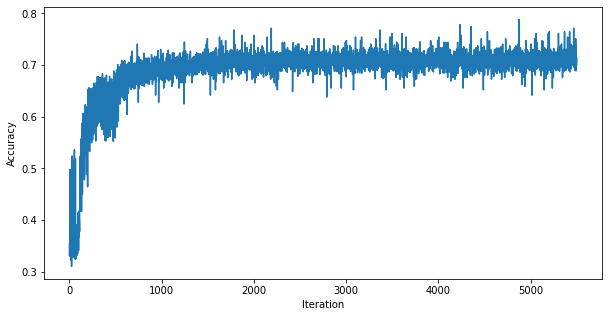

In [16]:
plt.figure(figsize=(10, 5))
plt.ylabel("Accuracy")
plt.xlabel('Iteration')
plt.plot(accs, label='Accuracy vs iteration')
plt.show()

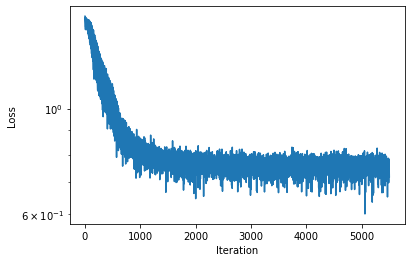

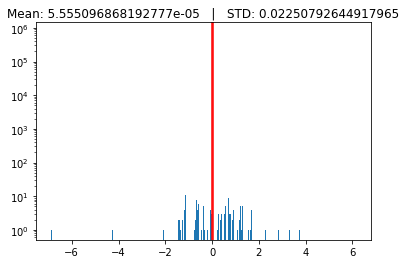

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Iteration')
plt.plot(losses, label='Loss vs iteration')
plt.yscale("log")
plt.show()

plt.figure()
weights = tree.inner_nodes.weight.cpu().detach().numpy().flatten()
plt.hist(weights, bins=500)
weights_std = np.std(weights)
weights_mean = np.mean(weights)
plt.axvline(weights_mean + weights_std, color='r')
plt.axvline(weights_mean - weights_std, color='r')
plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
plt.yscale("log")
plt.show()

# Tree Visualization

Average height: 10.105105105105105


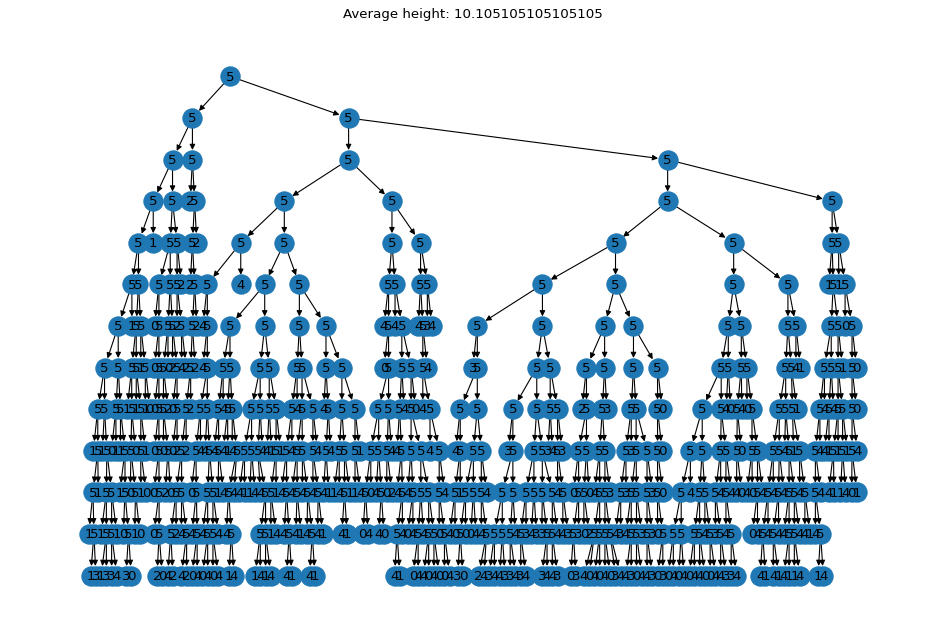

In [18]:
plt.figure(figsize=(15, 10), dpi=80)
avg_height, root = tree.visualize()

# Extract Rules

# Accumulate samples in the leaves

In [19]:
print(f"Number of patterns: {len(root.get_leaves())}")

Number of patterns: 333


In [20]:
method = 'MLE'

In [21]:
root.clear_leaves_samples()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
        root.accumulate_samples(data, method)

/home/eitan.k/.local/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Tighten boundaries

In [22]:
signal_names = dataset.dataset.all_signals
normalizers = torch.tensor([])
attr_names = []
for signal_name in signal_names:
    attr_names += [f"T{i}.{signal_name}" for i in range(sampled.shape[-1])]
    sensor_norm = torch.tensor([torch.tensor(dataset.dataset.sensor_maxs[signal_name]) for _ in range(sampled.shape[-1])])
    normalizers = torch.cat([normalizers, sensor_norm])
    

# print(attr_names)
leaves = root.get_leaves()
sum_comprehensibility = 0

for pattern_counter, leaf in enumerate(leaves):
    leaf.reset_path()
    leaf.tighten_with_accumulated_samples()
    conds = leaf.get_path_conditions(attr_names)
    for cond in conds:
        cond.weights = cond.weights / normalizers
    print(f"============== Pattern {pattern_counter + 1} ==============")
    sum_comprehensibility += sum([cond.comprehensibility for cond in conds])
    
print(f"Average comprehensibility: {sum_comprehensibility / len(leaves)}")

/home/eitan.k/EntangledExplainableClustering/soft_decision_tree/sdt_model.py:14: RuntimeWarning: divide by zero encountered in log
  return np.log(1 / (1 - x))


============== Pattern 1 ==============
============== Pattern 2 ==============
============== Pattern 3 ==============
============== Pattern 4 ==============
============== Pattern 5 ==============
============== Pattern 6 ==============
============== Pattern 7 ==============
============== Pattern 8 ==============
============== Pattern 9 ==============
============== Pattern 10 ==============
============== Pattern 11 ==============
============== Pattern 12 ==============
============== Pattern 13 ==============
============== Pattern 14 ==============
============== Pattern 15 ==============
============== Pattern 16 ==============
============== Pattern 17 ==============
============== Pattern 18 ==============
============== Pattern 19 ==============
============== Pattern 20 ==============
============== Pattern 21 ==============
============== Pattern 22 ==============
============== Pattern 23 ==============
============== Pattern 24 ==============
============== Pattern 25

============== Pattern 289 ==============
============== Pattern 290 ==============
============== Pattern 291 ==============
============== Pattern 292 ==============
============== Pattern 293 ==============
============== Pattern 294 ==============
============== Pattern 295 ==============
============== Pattern 296 ==============
============== Pattern 297 ==============
============== Pattern 298 ==============
============== Pattern 299 ==============
============== Pattern 300 ==============
============== Pattern 301 ==============
============== Pattern 302 ==============
============== Pattern 303 ==============
============== Pattern 304 ==============
============== Pattern 305 ==============
============== Pattern 306 ==============
============== Pattern 307 ==============
============== Pattern 308 ==============
============== Pattern 309 ==============
============== Pattern 310 ==============
============== Pattern 311 ==============
============== Pattern 312 =======

In [ ]:
# prune_tree(tree, factor=1.5)
correct = 0
tree = tree.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")

In [ ]:
print(f"Sparseness: {sparseness(tree.inner_nodes.weight)}")
layer = 0
sps = []
for i in range(tree.inner_nodes.weight.shape[0]):
    cur_layer = np.floor(np.log2(i+1))
    if cur_layer != layer:
        print(f"layer {layer}: {np.mean(sps)}")
        sps = []
        layer = cur_layer
    
    x_ = tree.inner_nodes.weight[i, :]
    sp = (len(x_) - torch.norm(x_, 0).item()) / len(x_)
    sps.append(sp)

## Prune the weights

In [ ]:
weights = tree.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}\n Kurtosis: {kurtosis(weights_layer)}")
    plt.yscale("log")
    plt.show()

## Verify that the accuracy didn't change too much

In [ ]:
correct = 0
tree_copy = tree_copy.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(tree_loader):
            data, target = data.to(device), target.to(device)
            output = tree_copy.forward(data)
            pred = output.data.max(1)[1]
            correct += pred.eq(target.view(-1).data).sum()

print(f"Accuracy: {correct / len(tree_loader.dataset)}")


In [ ]:
weights = tree_copy.inner_nodes.weight.cpu().detach().numpy()
for i in range(0, weights.shape[0], 20):
    plt.figure()
    weights_layer = weights[i, :]
    plt.hist(weights_layer, bins=500)
    weights_std = np.std(weights_layer)
    weights_mean = np.mean(weights_layer)
    plt.axvline(weights_mean + weights_std, color='r')
    plt.axvline(weights_mean - weights_std, color='r')
    plt.title(f"Mean: {weights_mean}   |   STD: {weights_std}")
    plt.yscale("log")
    plt.show()

In [ ]:

stack = LifoQueue()
edge_stack = LifoQueue()
stack.put(root)
rule_counter = 0
root.reset()
while not stack.empty():
    node = stack.get()
    if node.is_leaf():
        print(f"============== Rule {rule_counter} ==============")
        for stack_node, cond in zip(stack.queue, edge_stack.queue[1:]):
            print(repr(stack_node.get_condition(attr_names)) + cond)
            print()
        
        rule_counter += 1
        edge_stack.get()
        continue
          
    if node.left is not None and not node.left.visited:
        stack.put(node)
        stack.put(node.left)
        node.left.visited = True
        edge_stack.put(' < 0')
        continue
        
    if node.right is not None and not node.right.visited:
        stack.put(node)
        stack.put(node.right)
        node.right.visited = True
        edge_stack.put(' > 0')
        continue
        
    if node is not root:
        edge_stack.get()